In [7]:
import os
import time

import keras
import numpy as np
import optuna
import pandas as pd
import sklearn
import talib
import tensorflow as tf
import tensorflow_addons as tfa
import yfinance as yf
from keras.callbacks import Callback, CSVLogger, EarlyStopping, ModelCheckpoint
from keras.layers import (
    LSTM,
    GRU,
    Activation,
    BatchNormalization,
    Conv2D,
    Dense,
    Dropout,
    Flatten,
    MaxPooling2D,
)
from keras.models import Sequential
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LinearRegression
from sklearn.metrics import f1_score
from sklearn.preprocessing import MaxAbsScaler, OneHotEncoder
from tensorflow.keras.metrics import *
import pandas as pd
import numpy as np
import plotly.express as px
import yfinance as yf
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import math
import random
import datetime as dt
import time
from ipywidgets import IntProgress
from IPython.display import display
#from __future__ import print_function
import sys

<h1 style="font-size:40px;"> <center> CONSTANTS </center> </h1>

In [ ]:
SEED = 42

In [8]:
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)

<h1 style="font-size:40px;"> <center> FUNCTIONS </center> </h1>

In [9]:
def set_random_seed():
    tf.keras.utils.set_random_seed(SEED)


def HMA(df: pd.DataFrame, timeperiod: int = 14) -> float:
    """
    Hull Moving Average.
    Formula:
    HMA = WMA(2*WMA(n/2) - WMA(n)), sqrt(n)
    """
    hma = talib.WMA(
        2 * talib.WMA(df, int(timeperiod / 2)) - talib.WMA(df, timeperiod),
        int(np.sqrt(timeperiod)),
    )
    return hma


def money_flow_volume_series(df: pd.DataFrame) -> pd.Series:
    """
    Calculates money flow series
    """
    mfv = (
        df["Volume"]
        * (2 * df["Close"] - df["High"] - df["Low"])
        / (df["High"] - df["Low"])
    )
    return mfv


def money_flow_volume(df: pd.DataFrame, timeperiod: int = 20) -> pd.Series:
    """
    Calculates money flow volume, or q_t in our formula
    """
    return money_flow_volume_series(df).rolling(timeperiod).sum()


def CMF(df: pd.DataFrame, timeperiod: int = 20) -> pd.Series:
    """
    Calculates the Chaikin money flow
    """
    return money_flow_volume(df, timeperiod) / df["Volume"].rolling(timeperiod).sum()


def pltcolor(lst: list) -> list:
    cols = []
    for i in range(lst.shape[0]):
        if lst.iloc[i] == 1:
            cols.append("green")
        elif lst.iloc[i] == 2:
            cols.append("red")
    return cols


def trendNormalizePrices(prices: pd.DataFrame) -> None:
    df = prices.copy()
    df["rowNumber"] = list(range(len(df)))
    df["TN_Open"] = list(range(len(df)))
    df["TN_High"] = list(range(len(df)))
    df["TN_Low"] = list(range(len(df)))
    df["TN_Close"] = list(range(len(df)))
    for i in range(29, len(df)):
        model = LinearRegression()
        model.fit(
            np.array(df["rowNumber"].iloc[i - 29 : i + 1]).reshape(-1, 1),
            np.array(df["Close"].iloc[i - 29 : i + 1]),
        )
        prediction = model.predict(np.array([df["rowNumber"].iloc[i]]).reshape(-1, 1))
        df.iloc[i, df.columns.get_loc("TN_Open")] = df["Open"].iloc[i] - prediction
        df.iloc[i, df.columns.get_loc("TN_High")] = df["High"].iloc[i] - prediction
        df.iloc[i, df.columns.get_loc("TN_Low")] = df["Low"].iloc[i] - prediction
        df.iloc[i, df.columns.get_loc("TN_Close")] = df["Close"].iloc[i] - prediction
    df["Open"] = df["TN_Open"]
    df["High"] = df["TN_High"]
    df["Low"] = df["TN_Low"]
    df["Close"] = df["TN_Close"]
    df = df.drop(index=df.index[:30], axis=0)
    df = df.drop(
        columns=["TN_Open", "TN_High", "TN_Low", "TN_Close", "rowNumber"], axis=1
    )
    return df


def create_labels(prices: pd.DataFrame) -> None:
    df = prices.copy()
    df["Label"] = [0] * df.shape[0]
    for i in range(df.shape[0] - 10):
        s = set(df["Close"].iloc[i : i + 11])
        minPrice = sorted(s)[0]
        maxPrice = sorted(s)[-1]
        for j in range(i, i + 11):
            if df["Close"].iloc[j] == minPrice and (j - i) == 5:
                df.iloc[j, df.columns.get_loc("Label")] = 1
            elif df["Close"].iloc[j] == maxPrice and (j - i) == 5:
                df.iloc[j, df.columns.get_loc("Label")] = 2
    return df.iloc[6:-6]


def reverse_one_hot(predictions: np.array) -> np.array:
    return np.argmax(predictions, axis=1)


def one_hot(predictions: np.array) -> np.array:
    predictions_one_hot = []
    for i in predictions:
        prediction = [0, 0, 0]
        prediction[int(i)] = 1
        predictions_one_hot.append(prediction)
    return np.array(predictions_one_hot)


def number_null_and_nan(df: pd.DataFrame) -> int:
    na = pd.isna(df).sum().sum()
    null = df.isnull().sum().sum()
    return na + null


def adjustPrices(ohlcv:pd.DataFrame) -> None:
    adjustedRatio = ohlcv["Adj Close"]/ohlcv["Close"]
    ohlcv["High"] = ohlcv["High"] * adjustedRatio
    ohlcv["Low"] = ohlcv["Low"] * adjustedRatio
    ohlcv["Open"] = ohlcv["Open"] * adjustedRatio
    ohlcv["Close"] = ohlcv["Close"] * adjustedRatio  
    
    
def second_2_minute_converter(seconds:int) -> str:
    minutes = seconds // 60
    return f"{int(minutes)} minutes and {round(seconds%60, 2)} seconds"

    
def volatility(portfolio_returns:np.array) -> float:
    return np.std(portfolio_returns)


def beta(portfolio_returns:np.array, benchmark_returns:np.array) -> float:
    covariance = np.cov(portfolio_returns, benchmark_returns)[0][1]
    variance = np.var(benchmark_returns)
    return covariance/variance


# Higher and Lower Partial Moments


def hpm(portfolio_returns:np.array, threshold:float = 0, order:int = 1) -> float:
    threshold_array = np.empty(len(portfolio_returns))
    threshold_array.fill(threshold)
    diff = portfolio_returns - threshold_array
    diff = diff.clip(min=0)
    return np.sum(diff ** order) / len(portfolio_returns)


def lpm(portfolio_returns:np.array, threshold:float = 0, order:int = 1) -> float:
    threshold_array = np.empty(len(portfolio_returns))
    threshold_array.fill(threshold)
    diff = threshold_array - portfolio_returns
    diff = diff.clip(min=0)
    return np.sum(diff ** order) / len(portfolio_returns)


# Expected Shortfall Measures


def VaR(portfolio_returns:np.array, alpha:float = 0.05) -> float:
    sorted_returns = np.sort(portfolio_returns)
    index = int(alpha * len(sorted_returns))
    return abs(sorted_returns[index])


def cVaR(portfolio_returns:np.array, alpha:float = 0.05) -> float:
    sorted_returns = np.sort(portfolio_returns)
    index = int(alpha * len(sorted_returns))
    sum_var = sorted_returns[0]
    for i in range(1, index):
        sum_var += sorted_returns[i]
    return abs(sum_var / index)


# DrawDown Measures


def max_drawdown(portfolio_returns:pd.Series, risk_free_rate:float = 0.01) -> float:
    wealth_index=(1+portfolio_returns).cumprod()
    previous_peaks=wealth_index.cummax()
    drawdown=(wealth_index-previous_peaks)/previous_peaks
    return drawdown.min()


def average_drawdown(portfolio_returns:pd.Series, risk_free_rate:float = 0.01) -> float:
    wealth_index=(1+portfolio_returns).cumprod()
    previous_peaks=wealth_index.cummax()
    drawdown=(wealth_index-previous_peaks)/previous_peaks
    return drawdown.mean()


def average_drawdown_squared(portfolio_returns:pd.Series, risk_free_rate:float = 0.01) -> float:
    wealth_index = (1+portfolio_returns).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdown_squared = ((wealth_index-previous_peaks)/previous_peaks).pow(2)
    return drawdown_squared.mean()


# Measures Of Risk-Adjusted Return Based On Volatility


def treynor_ratio(portfolio_returns:np.array, benchmark_returns:np.array, risk_free_rate:float = 0.01) -> float:
    return (portfolio_returns.mean() - risk_free_rate) / beta(portfolio_returns, benchmark_returns) * math.sqrt(252)


def sharpe_ratio(portfolio_returns:np.array, risk_free_rate:float = 0.01) -> float:
    return (portfolio_returns.mean() - risk_free_rate) / volatility(portfolio_returns) * math.sqrt(252)


def information_ratio(portfolio_returns:np.array, benchmark_returns:np.array) -> float:
    diff = portfolio_returns - benchmark_returns
    return np.mean(diff) / np.std(diff) * math.sqrt(252)


def modigliani_ratio(portfolio_returns:np.array, benchmark_returns:np.array, risk_free_rate:float = 0.01) -> float:
    np_rf = np.empty(len(portfolio_returns))
    np_rf.fill(risk_free_rate)
    rdiff = portfolio_returns - np_rf
    bdiff = benchmark_returns - np_rf
    return (portfolio_returns.mean() - risk_free_rate) * (np.std(rdiff) / np.std(bdiff)) + risk_free_rate


# Measure Of Risk-Adjusted Return Based On Value At Risk


def excess_var(portfolio_returns:np.array, risk_free_rate:float = 0.01, alpha:float = 0.05) -> float:
    VaR_val = VaR(portfolio_returns, alpha)
    return (portfolio_returns.mean() - risk_free_rate) / (VaR_val if VaR_val != 0 else 10e-5)


def conditional_sharpe_ratio(portfolio_returns:np.array, risk_free_rate:float = 0.01, alpha:float = 0.05) -> float:
    cVaR_val = cVaR(portfolio_returns, alpha)
    return (portfolio_returns.mean() - risk_free_rate) / (cVaR_val if cVaR_val != 0 else 10e-5)


# Measures Of Risk-Adjusted Return Based On Partial Moments


def omega_ratio(portfolio_returns:np.array, risk_free_rate:float = 0.01, threshold:float = 0) -> float:
    return (portfolio_returns.mean() - risk_free_rate) / lpm(portfolio_returns, threshold, 1)


def sortino_ratio(portfolio_returns:np.array, risk_free_rate:float = 0.01, threshold:float = 0) -> float:
    return (portfolio_returns.mean() - risk_free_rate) / math.sqrt(lpm(portfolio_returns, threshold, 2))


def kappa_three_ratio(portfolio_returns:np.array, risk_free_rate:float = 0.01, threshold:float = 0) -> float:
    return (portfolio_returns.mean() - risk_free_rate) / math.pow(lpm(portfolio_returns, threshold, 3), 1/3)


def gain_loss_ratio(portfolio_returns:np.array, threshold:float = 0) -> float:
    return hpm(portfolio_returns, threshold, 1) / lpm(portfolio_returns, threshold, 1)


def upside_potential_ratio(portfolio_returns:np.array, threshold:float = 0) -> float:
    return hpm(portfolio_returns, threshold, 1) / math.sqrt(lpm(portfolio_returns, threshold, 2))


# Measures Of Risk-Adjusted Return Based On Drawdown Risk


def calmar_ratio(portfolio_returns: pd.Series, risk_free_rate:float = 0.01) -> float:
    return (np.array(portfolio_returns).mean() - risk_free_rate) / abs(max_drawdown(portfolio_returns)) * math.sqrt(252)


def sterling_ratio(portfolio_returns: pd.Series, risk_free_rate:float = 0.01) -> float:
    return (portfolio_returns.mean() - risk_free_rate) / average_drawdown(pd.Series(portfolio_returns), 
                                                                          risk_free_rate = 0.01)


def burke_ratio(portfolio_returns: pd.Series, risk_free_rate:float = 0.01) -> float:
    return (portfolio_returns.mean() - risk_free_rate) / math.sqrt(average_drawdown_squared(pd.Series(portfolio_returns), 
                                                                                            risk_free_rate = 0.01))


def plot_init(ticker:str, benchmark_ticker:str, risk_free_rate:float, start_date:list, end_date:list, 
              initial_capital:float, commission:float, alpha:float, threshold:float, order:int, short:bool,
              short_fee:float, trailing_take_profit:bool, take_profit:float,
              trailing_stop_loss:bool, stop_loss:float, leverage:int) -> None:
    fig = make_subplots(
    rows=1, cols=1,
    shared_xaxes=True,
    vertical_spacing=0.05,
    specs=[[{"type": "table"}]]
    )
    
    fig.add_trace(go.Table(
        columnwidth=[3, 1],
    header=dict(values=['Configurations', 'Values'], line_color='darkslategray',
                fill_color='lightgreen', align='center'),
    cells=dict(values=[["Ticker", "Benchmark Ticker", "Risk-free Rate", "Start Date", "End Date", 
                        "Inital Capital", "Commission", "Alpha", "Threshold", "Order", "Short", "Short Fee",
                        "Trailing Take Profit", "Take Profit",
                        "Trailing Stop Loss", "Stop Loss", "Leverage Ratio"],
                       [f"{ticker}",
                        f"{benchmark_ticker}",
                        round(risk_free_rate,2),   
                        start_date, 
                        end_date, 
                        f"{initial_capital}$", 
                        f"{commission}$", 
                        alpha,
                        threshold,
                        order,
                        ("is used" if short == True else "is not used"),
                        short_fee,
                        ("is used" if trailing_take_profit == True else "is not used"),
                        f"%{take_profit}", 
                        ("is used" if trailing_stop_loss == True else "is not used"),
                        f"%{stop_loss}", 
                        leverage
                       ]],
               line_color='darkslategray', fill_color='lightgoldenrodyellow', align='center')),
                 row=1, col=1)    
    fig.update_layout(width=700, height=700, title_text="INITIAL CONFIGURATION", title_x=0.5)
    fig.show()
    
    
def plot_tables(portfolio_value:np.array, benchmark_index:np.array, close_prices: np.array, total_trade_made:int,
                total_day_position_open: int, risk_free_rate:float = 0.01, alpha:float = 0.05, threshold:float = 0,
                order:int = 1, precision_point:int = 3, show_tables:bool = False) -> None:
    portfolio_returns = np.diff(portfolio_value) / portfolio_value[:-1]
    benchmark_returns = np.diff(benchmark_index) / benchmark_index[:-1]

    benchmark_return_value = round((benchmark_index[-1] - benchmark_index[1])/benchmark_index[1]*100, precision_point)
    buy_hold_return = round((close_prices[-1] - close_prices[0])/close_prices[0]*100, precision_point)
    total_return_value = round((portfolio_value[-1] - portfolio_value[0]) / portfolio_value[0] * 100, precision_point)
    year_count = len(close_prices) / 252
    try:
        annualized_return_value = round((math.pow(total_return_value/100 + 1, 1/year_count) - 1) * 100, precision_point)
        daily_return_value = round((math.pow(total_return_value/100 + 1, 1/(year_count*365)) - 1) * 100, precision_point)
    except:
        annualized_return_value = 0
        daily_return_value = 0
    profit_trade = (portfolio_returns > 0).sum()
    loss_trade = (portfolio_returns < 0).sum() - total_trade_made
    average_return_value = round(total_return_value/(profit_trade + loss_trade), 2)

    treynor_ratio_value = round(treynor_ratio(portfolio_returns, benchmark_returns, risk_free_rate), precision_point)
    sharpe_ratio_value = round(sharpe_ratio(portfolio_returns, risk_free_rate), precision_point)
    information_ratio_value = round(information_ratio(portfolio_returns, benchmark_returns), precision_point)
    modigliani_ratio_value = round(modigliani_ratio(portfolio_returns, benchmark_returns, risk_free_rate), precision_point)  
    excess_var_value = round(excess_var(portfolio_returns, risk_free_rate, alpha), precision_point) 
    conditional_sharpe_ratio_value = round(conditional_sharpe_ratio(portfolio_returns, risk_free_rate, alpha), precision_point) 
    omega_ratio_value = round(omega_ratio(portfolio_returns, risk_free_rate, threshold), precision_point) 
    sortino_ratio_value = round(sortino_ratio(portfolio_returns, risk_free_rate, threshold), precision_point)  
    kappa_3_ratio_value = round(kappa_three_ratio(portfolio_returns, risk_free_rate, threshold), precision_point)  
    gain_loss_ratio_value = round(gain_loss_ratio(portfolio_returns, threshold), precision_point)
    upside_potential_ratio_value = round(upside_potential_ratio(portfolio_returns, threshold), precision_point)
    calmar_ratio_value = round(calmar_ratio(pd.Series(portfolio_returns), risk_free_rate), precision_point) 
    sterling_ratio_value = round(sterling_ratio(pd.Series(portfolio_returns), risk_free_rate), precision_point)
    burke_ratio_value = round(burke_ratio(pd.Series(portfolio_returns), risk_free_rate), precision_point)

    volatility_value = round(volatility(portfolio_returns), precision_point) 
    beta_value = round(beta(portfolio_returns, benchmark_returns), precision_point) 
    hpm_value = round(hpm(portfolio_returns, threshold, order = 1), precision_point) 
    lpm_value = round(lpm(portfolio_returns, threshold, order = 1), precision_point)  
    var_value = round(VaR(portfolio_returns, alpha), precision_point) 
    cvar_value = round(cVaR(portfolio_returns, alpha), precision_point)
    average_dd_value = round(average_drawdown(pd.Series(portfolio_returns), risk_free_rate), precision_point)
    average_dd_2_value = round(average_drawdown_squared(pd.Series(portfolio_returns), risk_free_rate), precision_point)
    max_dd_value = round(max_drawdown(pd.Series(portfolio_returns), risk_free_rate), precision_point)
    
    total_trade_count = round(profit_trade + loss_trade, precision_point)
    annualized_total_trade_count = round(total_trade_count / year_count, precision_point)
    average_trade_duration_day = round(total_day_position_open / total_trade_count, precision_point)
  
    max_profit_trade = round(portfolio_returns.max()*100, precision_point)
    max_loss_trade = round(portfolio_returns.min()*100, precision_point)
    peak_capital = round(portfolio_value.max(), precision_point)
    through_capital = round(portfolio_value.min(), precision_point)
    
    if show_tables == True:
        fig = make_subplots(rows=3, cols=2,
                            shared_xaxes=True,
                            vertical_spacing=0.05,
                            specs=[
                                   [{"type": "table"}, {"type": "table"}],
                                   [{"type": "table"}, {"type": "table"}],
                                   [{"type": "table"}, {"type": "table"}],
                                  ]
                            )

        fig.add_trace(go.Table(columnwidth=[3, 1],
                               header=dict(values=['Returns', 'Values'], line_color='darkslategray',
                               fill_color='lightskyblue', align='center'),
                               cells=dict(values=[[
                                                   "Benchmark Return", 
                                                   "Buy&Hold Return", 
                                                   "Total Return", 
                                                   "Annualized Return",
                                                   "Daily Return",
                                                   "Average Return per Trade"
                                                   ],
                                                  [
                                                    f"%{benchmark_return_value}",
                                                    f"%{buy_hold_return}",
                                                    f"%{total_return_value}", 
                                                    f"%{annualized_return_value}",
                                                    f"%{daily_return_value}",
                                                    f"%{average_return_value}"
                                                   ]],

                             line_color='darkslategray', fill_color='lightcyan', align='center')),
                             row=1, col=1)   

        fig.add_trace(go.Table(columnwidth=[3, 1],
                               header=dict(values=['Risk-Adjusted Return Metrics', 'Values'], line_color='darkslategray',
                               fill_color='lightskyblue', align='center'),
                               cells=dict(values=[[
                                                    "Treynor Ratio", 
                                                    "Sharpe Ratio", 
                                                    "Information Ratio",
                                                    "Modigliani Ratio", 
                                                    f"Excess VaR (alpha={alpha})", 
                                                    f"Conditional Sharpe Ratio (alpha={alpha})", 
                                                    f"Omega Ratio (threshold={threshold})", 
                                                    f"Sortino Ratio (threshold={threshold})", 
                                                    f"Kappa 3 Ratio (threshold={threshold})", 
                                                    f"Gain Loss Ratio (threshold={threshold})",
                                                    f"Upside Potential Ratio (threshold={threshold})",
                                                    "Calmar Ratio", 
                                                    "Sterling Ratio",
                                                    "Burke Ratio"],
                                                   [
                                                    treynor_ratio_value, 
                                                    sharpe_ratio_value,
                                                    information_ratio_value, 
                                                    modigliani_ratio_value, 
                                                    excess_var_value, 
                                                    conditional_sharpe_ratio_value, 
                                                    omega_ratio_value,  
                                                    sortino_ratio_value,  
                                                    kappa_3_ratio_value,  
                                                    gain_loss_ratio_value, 
                                                    upside_potential_ratio_value,  
                                                    calmar_ratio_value,
                                                    sterling_ratio_value, 
                                                    burke_ratio_value,
                                                    ]],
                                 line_color='darkslategray', fill_color='lightcyan', align='center')),
                                 row=1, col=2)

        fig.add_trace(go.Table(columnwidth=[3, 1],
                               header=dict(values=['Risk Metrics', 'Values'], line_color='darkslategray',
                               fill_color='lightskyblue', align='center'),
                               cells=dict(values=[[
                                                    "Volatility", 
                                                    "Beta", 
                                                    f"Higher Partial Moment (threshold={threshold}, order={order})", 
                                                    f"Lower Partial Moment (threshold={threshold}, order={order})", 
                                                    f"VaR (alpha={alpha})", 
                                                    f"CVaR (alpha={alpha})", 
                                                    "Average Drawdown",
                                                    "Average Drawdown Squared", 
                                                    "Maximum Drawdown"],
                                                   [
                                                    volatility_value,  
                                                    beta_value,
                                                    hpm_value,  
                                                    lpm_value,  
                                                    var_value, 
                                                    cvar_value,  
                                                    average_dd_value, 
                                                    average_dd_2_value,  
                                                    max_dd_value
                                                    ]],
                             line_color='darkslategray', fill_color='lightcyan', align='center')),
                             row=2, col=1)

        fig.add_trace(go.Table(columnwidth=[3, 1],
                               header=dict(values=['Counts', 'Values'], line_color='darkslategray',
                               fill_color='lightskyblue', align='center'),
                               cells=dict(values=[[
                                                   "Total trade count", 
                                                   "Profitable trade count", 
                                                   "Loss trade count",
                                                   "Win Rate",
                                                   "Annualized total trade count", 
                                                   "Average trade duration day",
                                                   "Exposure Time"
                                                    ],
                                                   [
                                                    total_trade_count,
                                                    profit_trade, 
                                                    loss_trade,
                                                    f"%{round(profit_trade/total_trade_count*100, precision_point)}",
                                                    annualized_total_trade_count,  
                                                    average_trade_duration_day,
                                                    f"%{round(total_day_position_open/len(close_prices), precision_point)}"
                                                   ]],
                              line_color='darkslategray', fill_color='lightcyan', align='center')),
                              row=2, col=2)

        fig.add_trace(go.Table(columnwidth=[3, 1],
                               header=dict(values=['Extremums', 'Values'], line_color='darkslategray',
                               fill_color='lightskyblue', align='center'),
                               cells=dict(values=[[
                                                   "Max profit for a trade", 
                                                   "Max loss for a trade", 
                                                   "Max capital value", 
                                                   "Min capital value"
                                                   ],
                                                   [
                                                    f"%{max_profit_trade}",
                                                    f"%{max_loss_trade}",
                                                    peak_capital,
                                                    through_capital
                                                   ]],
                                line_color='darkslategray', fill_color='lightcyan', align='center')),
                                row=3, col=1)
        fig.update_layout(width=1000, height=1000, title_text="BACKTEST RESULTS", title_x=0.5)
        fig.show()
    
    return {"Total Return": total_return_value, "Treynor Ratio": treynor_ratio_value, 
            "Sharpe Ratio": sharpe_ratio_value, "Information Ratio": information_ratio_value,
            "Modigliani Ratio": modigliani_ratio_value, "Excess VaR": excess_var_value, 
            "Conditional Sharpe Ratio": conditional_sharpe_ratio_value, "Omega Ratio": omega_ratio_value, 
            "Sortino Ratio": sortino_ratio_value, "Kappa 3 Ratio": kappa_3_ratio_value, 
            "Gain Loss Ratio": gain_loss_ratio_value, "Upside Potential Ratio": upside_potential_ratio_value, 
            "Calmar Ratio": calmar_ratio_value, "Sterling Ratio": sterling_ratio_value,
            "Burke Ratio": burke_ratio_value, "Volatility": volatility_value, "Beta": beta_value,
            "Higher Partial Moment": hpm_value, "Lower Partial Moment": lpm_value, 
            "VaR": var_value, "CVaR": cvar_value, "Average Drawdown": average_dd_value,
            "Average Drawdown Squared": average_dd_2_value, "Maximum Drawdown": max_dd_value}


def plot_charts(ticker: str, ohlcv: pd.DataFrame, predictions: np.array, portfolio_value: np.array, liquidated:bool) -> None:
    if liquidated == True:
        print("\n----------------------------\nThis strategy is liquidated\n-------------------------------")
    fig = make_subplots(rows=2, cols=1, shared_xaxes=False, vertical_spacing=0.1, 
                        subplot_titles=(f"OHLC of '{ticker}'", f"Volume of '{ticker}'"), row_width=[1, 5])
    fig.add_trace(go.Candlestick(x=ohlcv.index, open=ohlcv['Open'],
                                 high=ohlcv['High'], low=ohlcv['Low'], 
                                 close=ohlcv['Close'], name = "OHLC"), 
                                 row=1, col=1)
    fig.add_trace(go.Bar(x=ohlcv.index, y=ohlcv['Volume'], name = "Volume"),
                         row=2, col=1)
    fig.update(layout_xaxis_rangeslider_visible=False)
    fig.update_layout(autosize=True, width=950, height=950,)
    fig.show()
    
    fig = go.Figure()
    buy_labels = (predictions==1)
    sell_labels = (predictions==2)
    fig.add_trace(go.Scatter(x=ohlcv.index, y=ohlcv["Close"], mode='lines', 
                             line=dict(color="#222266"), name='Close Price'))
    fig.add_trace(go.Scatter(x=ohlcv[buy_labels].index, y=ohlcv[buy_labels]["Close"],
                             mode='markers', marker=dict(size=6, color="#2cc05c"), name = "Buy"))
    fig.add_trace(go.Scatter(x=ohlcv[sell_labels].index, y=ohlcv[sell_labels]["Close"],
                             mode='markers', marker=dict(size=6, color='#f62728'), name = "Sell"))
    fig.update_layout(title=f"Close Price with Predictions of '{ticker}'", title_x=0.5)
    fig.show()
    
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=ohlcv.index, y=portfolio_value, mode='lines', 
                             line=dict(color="#222266"), name='Portfolio Value'))
    fig.update_layout(title="Portfolio Value", title_x=0.5)
    fig.show()
    
    
def financial_evaluation(holdLabel:int = 0, buyLabel:int = 1, sellLabel:int = 2, ticker:str = "SPY", 
                         benchmark_ticker:str = "SPY", ohlcv: pd.DataFrame = None, predictions: np.array = None, 
                         risk_free_rate:float = 0.01/252, initial_capital:float = 1000, commission:float = 1, 
                         alpha:float = 0.05, threshold:float = 0, order:int = 1, order_type:str = "market", 
                         short:bool = False, short_fee:float = 1, trailing_take_profit:bool = False, take_profit:float = 10,
                         trailing_stop_loss:bool = False, stop_loss:float = 10, leverage:int = 1, miss_rate:int = 10, 
                         show_initial_configuration:bool = True, show_tables:bool = True, show_charts:bool = True, 
                         show_time:bool = True, precision_point:int = 3) -> dict:  
    start = time.time()
    if ohlcv.empty:
        print("OHLCV data is empty")
        return
    if predictions.all() == None:
        print("Predictions data is empty")
        return
    start_date = ohlcv.index[0]
    end_date = ohlcv.index[-1]
    benchmark_index = np.array(yf.download(benchmark_ticker, start_date, 
                                          end_date, progress = False, interval="1d")["Adj Close"])
    open_prices = ohlcv["Open"].values    
    high_prices = ohlcv["High"].values    
    low_prices = ohlcv["Low"].values    
    close_prices = ohlcv["Close"].values
    capital = initial_capital
    long_open = False
    short_open = False
    long_price = 0.0
    short_price = 0.0
    stop_loss_price = 0.0
    take_profit_price = 0.0
    total_day_position_open = 0
    total_trade_made = 0 
    portfolio_value = np.zeros(len(predictions)+1)
    portfolio_value[0] = initial_capital
    liquidated = False
    if short == False:
        for i in range(len(predictions)):     
            change = 0
            if long_open == True and\
            (low_prices[i] <= stop_loss_price <= high_prices[i] or low_prices[i] <= take_profit_price <= high_prices[i]):
                 predictions[i] = sellLabel
            if predictions[i] == buyLabel and long_open == False:
                if order_type == "market":
                    long_open = True
                    long_price = round(random.uniform(low_prices[i], high_prices[i]), 6)
                elif order_type == "limit" and random.randint(1, miss_rate) != 1:
                    long_open = True
                    long_price = open_prices[i]
                if long_open == True: 
                    stop_loss_price = long_price * (1-stop_loss/100)
                    take_profit_price = long_price * (1+take_profit/100)
                    capital -= commission
            elif predictions[i] == sellLabel and long_open == True:
                if order_type == "market":
                    long_open = False
                    change = (round(random.uniform(low_prices[i], high_prices[i]), 6) - long_price) / long_price * leverage                 
                elif order_type == "limit" and random.randint(1, miss_rate) != 1:
                    long_open = False
                    change = (open_prices[i] - long_price) / long_price * leverage
                if long_open == False:
                    capital *= 1 + change
                    capital -= commission
                    if capital <= 0:
                        liquidated = True
                        break
                    total_trade_made += 1
            if long_open == True:
                total_day_position_open += 1
            portfolio_value[i+1] = capital
            if long_open == True and trailing_stop_loss == True:
                stop_loss_price = close_prices[i] * (1-stop_loss/100) 
            if long_open == True and trailing_take_profit == True:
                take_profit_price = close_prices[i] * (1+take_profit/100)
    elif short == True:
        for i in range(len(predictions)):
            change = 0
            if predictions[i] != 0 and long_open == False and short_open == False:
                if predictions[i] == buyLabel:
                    if order_type == "market":
                        long_open = True
                        long_price = round(random.uniform(low_prices[i], high_prices[i]), 6)
                    elif order_type == "limit" and random.randint(1, miss_rate) != 1:
                        long_open = True
                        long_price = open_prices[i]
                    if long_open == True:   
                        capital -= commission
                        total_trade_made += 1
                        stop_loss_price = long_price * (1-stop_loss/100)
                        take_profit_price = long_price * (1+take_profit/100)                       
                elif predictions[i] == sellLabel:
                    if order_type == "market":
                        short_open = True
                        short_price = round(random.uniform(low_prices[i], high_prices[i]), 6)
                    elif order_type == "limit" and random.randint(1, miss_rate) != 1:
                        short_open = True
                        short_price = open_prices[i]
                    if short_open == True:   
                        capital -= commission + short_fee
                        total_trade_made += 1
                        stop_loss_price = short_price * (1+stop_loss/100)
                        take_profit_price = short_price * (1-take_profit/100)  
            if long_open == True and \
            (low_prices[i] <= stop_loss_price <= high_prices[i] or low_prices[i] <= take_profit_price <= high_prices[i]):
                 predictions[i] = sellLabel
            if short_open == True and \
            (low_prices[i] <= stop_loss_price <= high_prices[i] or low_prices[i] <= take_profit_price <= high_prices[i]):
                 predictions[i] = buyLabel
            if predictions[i] == sellLabel and long_open == True and short_open == False:
                if order_type == "market":
                    long_open = False
                    short_open = True
                    short_price = round(random.uniform(low_prices[i], high_prices[i]), 6)
                    change = (short_price - long_price) / long_price * leverage                    
                elif order_type == "limit" and random.randint(1, miss_rate) != 1:
                    long_open = False
                    short_open = True
                    short_price = open_prices[i]
                    change = (short_price - long_price) / long_price * leverage
                if long_open == False and short_open == True:   
                    capital *= 1 + change
                    capital -= commission + short_fee
                    if capital <= 0:
                        liquidated = True
                        break
                    total_trade_made += 1
                    stop_loss_price = short_price * (1+stop_loss/100)
                    take_profit_price = short_price * (1-take_profit/100)  
            elif predictions[i] == buyLabel and long_open == False and short_open == True:
                if order_type == "market":
                    long_open = True
                    short_open = False
                    long_price = round(random.uniform(low_prices[i], high_prices[i]), 6)
                    change = (short_price - long_price) / short_price * leverage
                elif order_type == "limit" and random.randint(1, miss_rate) != 1:
                    long_open = True
                    short_open = False
                    long_price = open_prices[i]
                    change = (short_price - long_price) / short_price * leverage
                if long_open == True and short_open == False:   
                    capital *= 1 + change
                    capital -= commission
                    if capital <= 0:
                        liquidated = True
                        break
                    total_trade_made += 1
                    stop_loss_price = long_price * (1-stop_loss/100)
                    take_profit_price = long_price * (1+take_profit/100)    
            if long_open == True or short_open == True:
                total_day_position_open += 1
            portfolio_value[i+1] = capital
            if trailing_stop_loss == True and short_open == False and long_open == True:
                stop_loss_price = close_prices[i] * (1-stop_loss/100) 
            if trailing_stop_loss == True and short_open == True and long_open == False:
                stop_loss_price = close_prices[i] * (1+stop_loss/100) 
            if trailing_take_profit == True and short_open == False and long_open == True:
                take_profit_price = close_prices[i] * (1+take_profit/100)
            if trailing_take_profit == True and short_open == True and long_open == False:
                take_profit_price = close_prices[i] * (1-take_profit/100)
    if total_trade_made == 0:
        print("No trade executed")
        return
    end = time.time()
    if show_time == True:
        print(f"\nBacktest was completed in {second_2_minute_converter(end-start)}.\n")
    if show_initial_configuration:
        plot_init(ticker, benchmark_ticker, risk_free_rate, start_date, end_date, 
                  initial_capital, commission, alpha, threshold, order, short,
                  short_fee, trailing_take_profit, take_profit,
                  trailing_stop_loss, stop_loss, leverage)
    metrics = plot_tables(portfolio_value[:i], benchmark_index[:i], close_prices[:i], total_trade_made, total_day_position_open, 
                          risk_free_rate, alpha, threshold, order, precision_point, show_tables)
    if show_charts:
        plot_charts("SPY", ohlcv[:i], predictions[:i], portfolio_value[:i], liquidated) 
    return metrics

<h1 style="font-size:40px;"> <center> DATA PREPROCESSING </center> </h1>

In [10]:
prices = yf.download(
    "SPY",
    start="2009-09-20",
    end="2023-01-01",
    interval="1d",
    progress=False,
    auto_adjust=True,
)
prices

Open        High         Low       Close  \
Date                                                                        
2009-09-21 00:00:00-04:00   82.204704   83.066422   82.026154   82.639442   
2009-09-22 00:00:00-04:00   83.128546   83.353680   82.755909   83.120781   
2009-09-23 00:00:00-04:00   83.314846   83.866034   82.282337   82.429840   
2009-09-24 00:00:00-04:00   82.608389   82.786940   81.164431   81.521538   
2009-09-25 00:00:00-04:00   81.342972   81.793240   80.807308   81.086784   
...                               ...         ...         ...         ...   
2022-12-23 00:00:00-05:00  379.649994  383.059998  378.029999  382.910004   
2022-12-27 00:00:00-05:00  382.790009  383.149994  379.649994  381.399994   
2022-12-28 00:00:00-05:00  381.329987  383.390015  376.420013  376.660004   
2022-12-29 00:00:00-05:00  379.630005  384.350006  379.079987  383.440002   
2022-12-30 00:00:00-05:00  380.640015  382.579987  378.429993  382.429993   

                              Volume  
Date                                  
2009-09-21 00:00:00-04:00  151892000  
2009-09-22 00:00:00-04:00  143126700  
2009-09-23 00:00:00-04:00  225947400  
2009-09-24 00:00:00-04:00  228636800  
2009-09-25 00:00:00-04:00  204059000  
...                              ...  
2022-12-23 00:00:00-05:00   59857300  
2022-12-27 00:00:00-05:00   51638200  
2022-12-28 00:00:00-05:00   70911500  
2022-12-29 00:00:00-05:00   66970900  
2022-12-30 00:00:00-05:00   83975100  

[3344 rows x 5 columns]

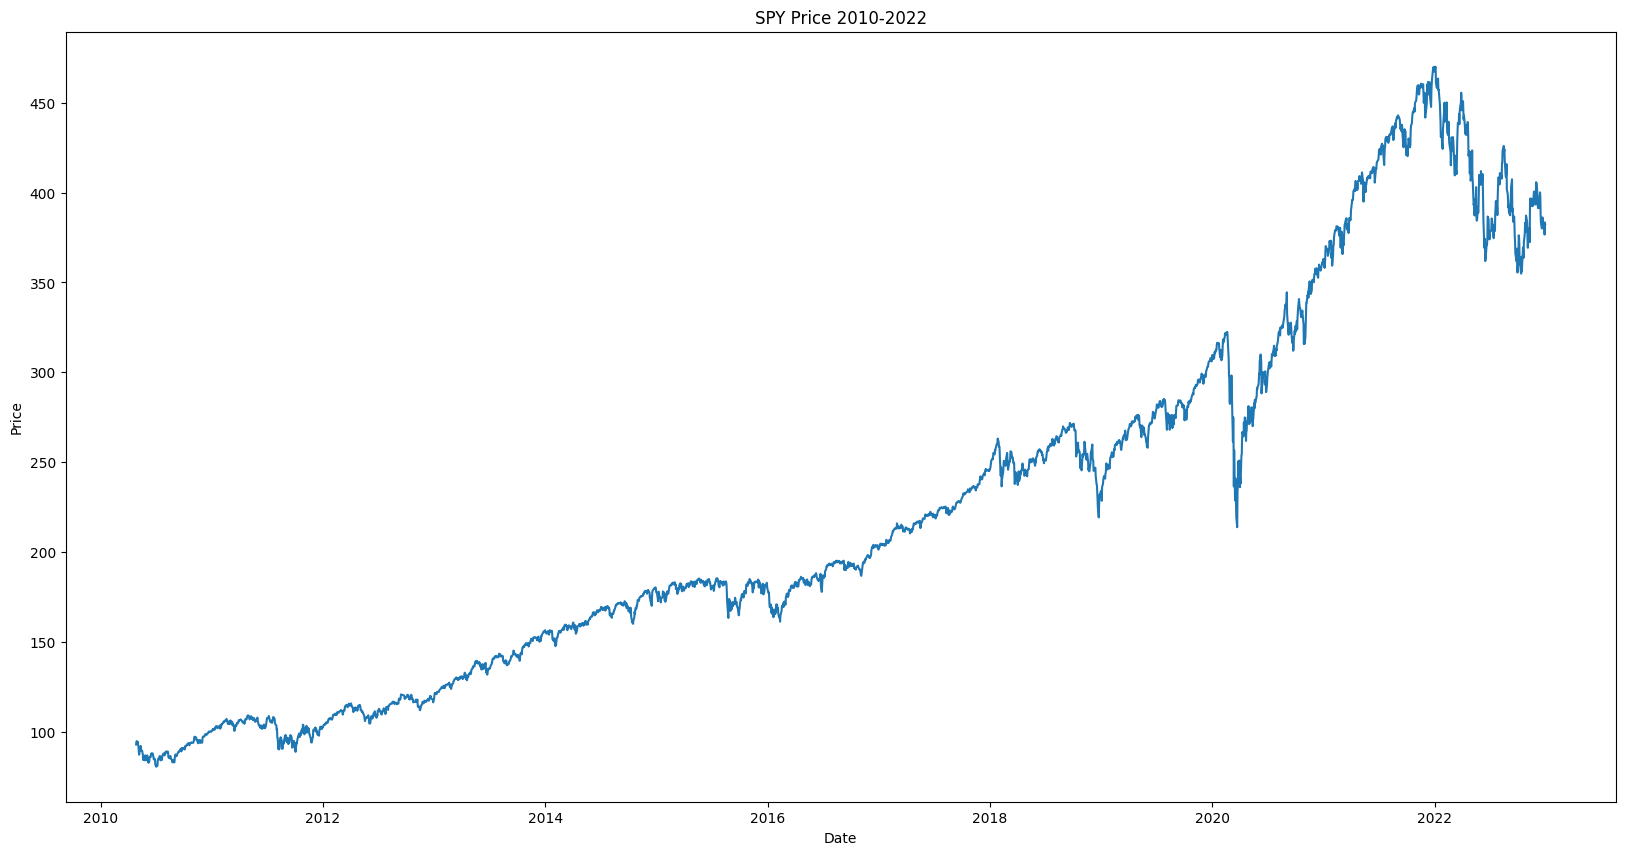

In [11]:
plt.figure(figsize=(20, 10))
plt.title("SPY Price 2010-2022")
plt.xlabel("Date")
plt.ylabel("Price")
plt.plot(prices[["Close"]].iloc[150:, :])

<h1 style="font-size:30px;"> <center> Trend Normalize and Visualize </center> </h1>

In [12]:
tn_prices = trendNormalizePrices(prices)
tn_prices

Open      High       Low     Close     Volume
Date                                                                        
2009-11-02 00:00:00-05:00 -2.497198 -1.503501 -3.312333 -2.349695  254222900
2009-11-03 00:00:00-05:00 -2.646037 -1.823132 -2.801299 -1.939581  228362600
2009-11-04 00:00:00-05:00 -1.110678 -0.474095 -1.778316 -1.568711  247996700
2009-11-05 00:00:00-05:00 -0.968807 -0.021700 -1.139599 -0.044988  180015300
2009-11-06 00:00:00-05:00 -0.466994  0.418013 -0.630020  0.208402  170954100
...                             ...       ...       ...       ...        ...
2022-12-23 00:00:00-05:00 -7.306054 -3.896050 -8.926049 -4.046044   59857300
2022-12-27 00:00:00-05:00 -2.835277 -2.475292 -5.975292 -4.225292   51638200
2022-12-28 00:00:00-05:00 -2.236787 -0.176759 -7.146761 -6.906770   70911500
2022-12-29 00:00:00-05:00 -3.069598  1.650403 -3.619617  0.740399   66970900
2022-12-30 00:00:00-05:00 -0.947872  0.992100 -3.157894  0.842106   83975100

[3314 rows x 5 columns]

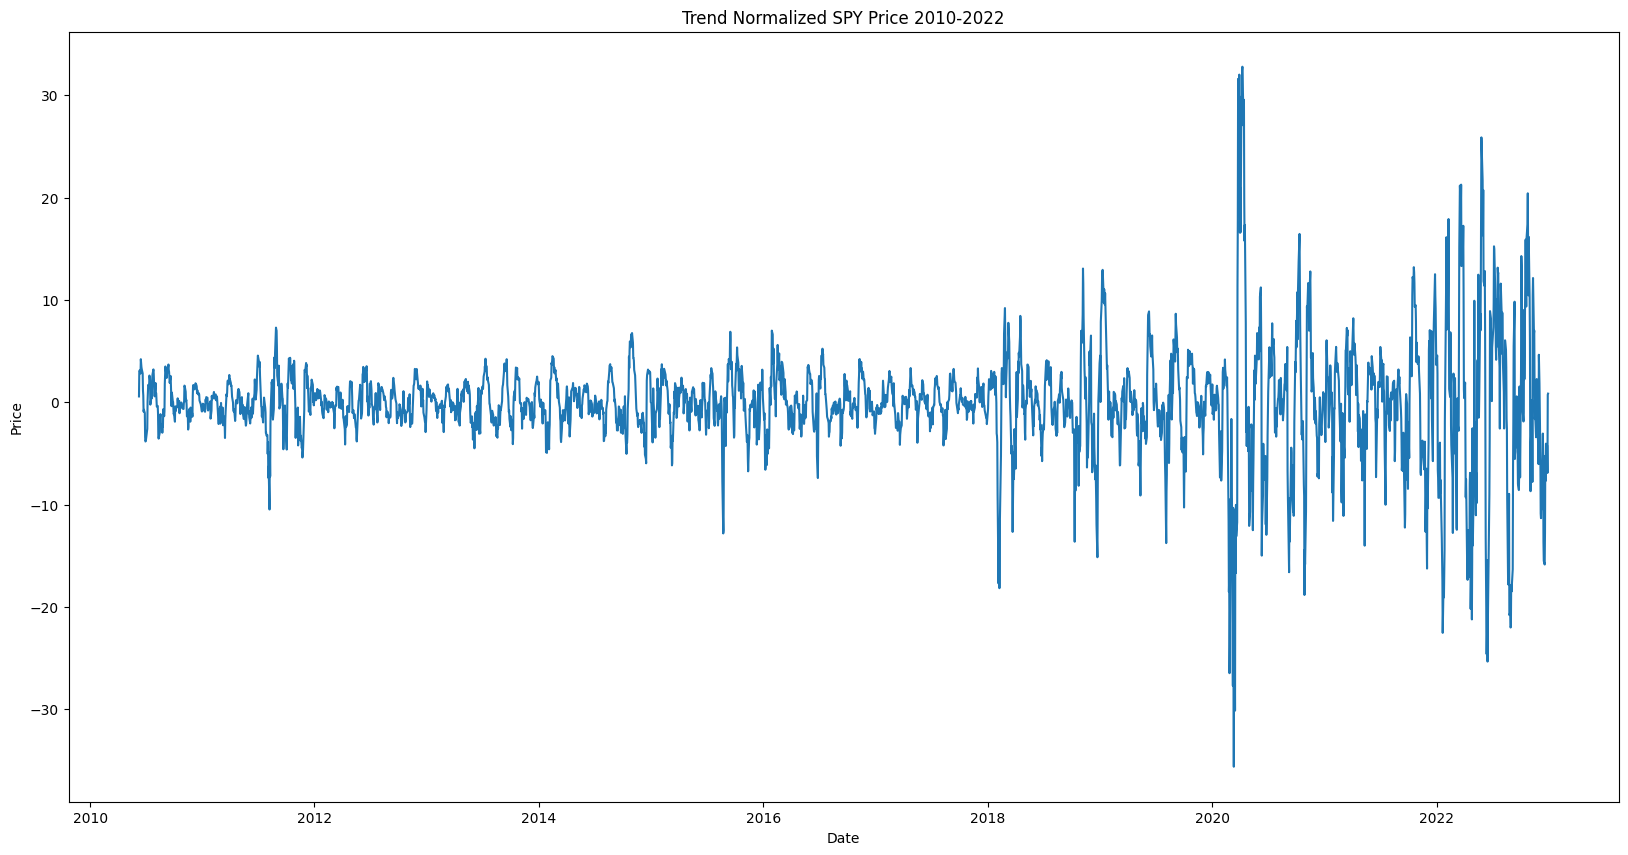

In [13]:
plt.figure(figsize=(20, 10))
plt.title("Trend Normalized SPY Price 2010-2022")
plt.xlabel("Date")
plt.ylabel("Price")
plt.plot(tn_prices[["Close"]].iloc[150:, :])

<h1 style="font-size:30px;"> <center> Adding Technical Indicators </center> </h1>

In [14]:
prices_and_indicators = tn_prices.copy()

In [15]:
for i in range(7, 30):
    prices_and_indicators[f"RSI-{i}"] = talib.RSI(
        prices_and_indicators["Close"], timeperiod=i
    )
    prices_and_indicators[f"WILLR-{i}"] = talib.WILLR(
        prices_and_indicators["High"],
        prices_and_indicators["Low"],
        prices_and_indicators["Close"],
        timeperiod=i,
    )
    prices_and_indicators[f"STOCH-{i}"] = talib.STOCH(
        prices_and_indicators["High"],
        prices_and_indicators["Low"],
        prices_and_indicators["Close"],
        fastk_period=i + 7,
        slowk_period=i - 4,
    )[0]
    prices_and_indicators[f"STOCHF-{i}"] = talib.STOCHF(
        prices_and_indicators["High"],
        prices_and_indicators["Low"],
        prices_and_indicators["Close"],
        fastk_period=i - 2,
        fastd_period=i - 4,
    )[0]
    prices_and_indicators[f"SMA-{i}"] = talib.SMA(
        prices_and_indicators["Close"], timeperiod=i
    )
    prices_and_indicators[f"EMA-{i}"] = talib.EMA(
        prices_and_indicators["Close"], timeperiod=i
    )
    prices_and_indicators[f"WMA-{i}"] = talib.WMA(
        prices_and_indicators["Close"], timeperiod=i
    )
    prices_and_indicators[f"HMA-{i}"] = HMA(
        prices_and_indicators["Close"], timeperiod=i
    )
    prices_and_indicators[f"TEMA-{i}"] = talib.TEMA(
        prices_and_indicators["Close"], timeperiod=i
    )
    prices_and_indicators[f"PPO-{i}"] = talib.PPO(
        prices_and_indicators["Close"], fastperiod=i, slowperiod=i + 14
    )
    prices_and_indicators[f"ROC-{i}"] = talib.ROC(
        prices_and_indicators["Close"], timeperiod=i
    )
    prices_and_indicators[f"CMO-{i}"] = talib.CMO(
        prices_and_indicators["Close"], timeperiod=i
    )
    prices_and_indicators[f"MACD-{i}"] = talib.MACD(
        prices_and_indicators["Close"], fastperiod=i, slowperiod=i + 14
    )[0]
    prices_and_indicators[f"MAMA-{i}"] = talib.MAMA(
        prices_and_indicators["Close"], fastlimit=1 / i, slowlimit=1 / (i + 14)
    )[0]
    prices_and_indicators[f"STOCHRSI-{i}"] = talib.STOCHRSI(
        prices_and_indicators["Close"], timeperiod=i
    )[0]
    prices_and_indicators[f"DX-{i}"] = talib.DX(
        prices_and_indicators["High"],
        prices_and_indicators["Low"],
        prices_and_indicators["Close"],
        timeperiod=i,
    )
    prices_and_indicators[f"ADXR-{i}"] = talib.ADXR(
        prices_and_indicators["High"],
        prices_and_indicators["Low"],
        prices_and_indicators["Close"],
        timeperiod=i,
    )
    prices_and_indicators[f"CCI-{i}"] = talib.CCI(
        prices_and_indicators["High"],
        prices_and_indicators["Low"],
        prices_and_indicators["Close"],
        timeperiod=i,
    )
    prices_and_indicators[f"PLUS_DI-{i}"] = talib.PLUS_DI(
        prices_and_indicators["High"],
        prices_and_indicators["Low"],
        prices_and_indicators["Close"],
        timeperiod=i,
    )
    prices_and_indicators[f"MINUS_DI-{i}"] = talib.MINUS_DI(
        prices_and_indicators["High"],
        prices_and_indicators["Low"],
        prices_and_indicators["Close"],
        timeperiod=i,
    )
    prices_and_indicators[f"ATR-{i}"] = talib.ATR(
        prices_and_indicators["High"],
        prices_and_indicators["Low"],
        prices_and_indicators["Close"],
        timeperiod=i,
    )
    prices_and_indicators[f"SAR-{i}"] = talib.SAR(
        prices_and_indicators["High"], prices_and_indicators["Low"], maximum=1 / i
    )
    prices_and_indicators[f"PLUS_DM-{i}"] = talib.PLUS_DM(
        prices_and_indicators["High"], prices_and_indicators["Low"], timeperiod=i
    )
    prices_and_indicators[f"AROONOSC-{i}"] = talib.AROONOSC(
        prices_and_indicators["High"], prices_and_indicators["Low"], timeperiod=i
    )
    prices_and_indicators[f"MIDPRICE-{i}"] = talib.MIDPRICE(
        prices_and_indicators["High"], prices_and_indicators["Low"], timeperiod=i
    )
    prices_and_indicators[f"MFI-{i}"] = talib.MFI(
        prices_and_indicators["High"],
        prices_and_indicators["Low"],
        prices_and_indicators["Close"],
        prices_and_indicators["Volume"],
        timeperiod=i,
    )
    prices_and_indicators[f"ADOSC-{i}"] = talib.ADOSC(
        prices_and_indicators["High"],
        prices_and_indicators["Low"],
        prices_and_indicators["Close"],
        prices_and_indicators["Volume"],
        fastperiod=i - 4,
        slowperiod=i + 3,
    )
    prices_and_indicators[f"BBANDS-{i}"] = talib.BBANDS(
        prices_and_indicators["Close"], timeperiod=i
    )[1]
    prices_and_indicators[f"CMF-{i}"] = CMF(prices_and_indicators, timeperiod=i)
prices_and_indicators["BOP"] = talib.BOP(
    prices_and_indicators["Open"],
    prices_and_indicators["High"],
    prices_and_indicators["Low"],
    prices_and_indicators["Close"],
)
prices_and_indicators["TRANGE"] = talib.TRANGE(
    prices_and_indicators["High"],
    prices_and_indicators["Low"],
    prices_and_indicators["Close"],
)
prices_and_indicators["SAREXT"] = talib.SAREXT(
    prices_and_indicators["High"], prices_and_indicators["Low"]
)
prices_and_indicators["AD"] = talib.AD(
    prices_and_indicators["High"],
    prices_and_indicators["Low"],
    prices_and_indicators["Close"],
    prices_and_indicators["Volume"],
)
prices_and_indicators["OBV"] = talib.OBV(
    prices_and_indicators["Close"], prices_and_indicators["Volume"]
)
prices_and_indicators.dropna(inplace=True)

C:\Users\NEO\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
C:\Users\NEO\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
C:\Users\NEO\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using

C:\Users\NEO\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:129: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
C:\Users\NEO\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:134: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
C:\Users\NEO\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:137: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once us

In [16]:
prices_and_indicators

Open      High       Low     Close     Volume  \
Date                                                                           
2010-03-08 00:00:00-05:00  1.437764  1.640690  1.289467  1.445565  114631200   
2010-03-09 00:00:00-05:00  0.732028  1.559357  0.685200  1.145693  154556700   
2010-03-10 00:00:00-05:00  0.733598  1.334582  0.655549  1.092628  186088800   
2010-03-11 00:00:00-05:00  0.384636  0.993432  0.111461  0.970012  160791100   
2010-03-12 00:00:00-05:00  0.955883  0.971497  0.323679  0.573439  162074800   
...                             ...       ...       ...       ...        ...   
2022-12-23 00:00:00-05:00 -7.306054 -3.896050 -8.926049 -4.046044   59857300   
2022-12-27 00:00:00-05:00 -2.835277 -2.475292 -5.975292 -4.225292   51638200   
2022-12-28 00:00:00-05:00 -2.236787 -0.176759 -7.146761 -6.906770   70911500   
2022-12-29 00:00:00-05:00 -3.069598  1.650403 -3.619617  0.740399   66970900   
2022-12-30 00:00:00-05:00 -0.947872  0.992100 -3.157894  0.842106   83975100   

                               RSI-7    WILLR-7    STOCH-7   STOCHF-7  \
Date                                                                    
2010-03-08 00:00:00-05:00  47.617912 -52.608275  36.667271  47.391725   
2010-03-09 00:00:00-05:00  43.011823 -71.220709  32.181152  36.783090   
2010-03-10 00:00:00-05:00  42.169695 -73.180978  23.658139  34.405833   
2010-03-11 00:00:00-05:00  40.055513 -52.972971  22.429232  47.317373   
2010-03-12 00:00:00-05:00  33.683455 -74.538963  21.170288  30.209866   
...                              ...        ...        ...        ...   
2022-12-23 00:00:00-05:00  58.661033 -11.867633  52.154892  88.025262   
2022-12-27 00:00:00-05:00  58.183036 -13.021895  53.599562  84.670466   
2022-12-28 00:00:00-05:00  50.938828 -38.641164  54.731521  50.023428   
2022-12-29 00:00:00-05:00  65.309529  -5.338817  61.622018  94.049733   
2022-12-30 00:00:00-05:00  65.466485  -5.285231  68.916974  92.357583   

                               SMA-7     EMA-7     WMA-7     HMA-7    TEMA-7  \
Date                                                                           
2010-03-08 00:00:00-05:00   1.631661  1.641458  1.573675  1.487752  1.372958   
2010-03-09 00:00:00-05:00   1.564092  1.517517  1.452183  1.349654  1.172142   
2010-03-10 00:00:00-05:00   1.426109  1.411295  1.334317  1.094566  1.044281   
2010-03-11 00:00:00-05:00   1.298424  1.300974  1.220293  0.908011  0.919431   
2010-03-12 00:00:00-05:00   1.178318  1.119090  1.039047  0.650196  0.638609   
...                              ...       ...       ...       ...       ...   
2022-12-23 00:00:00-05:00 -10.671806 -8.082640 -8.702957 -3.140816 -5.428279   
2022-12-27 00:00:00-05:00  -9.321957 -7.118303 -7.091328 -2.335373 -4.017593   
2022-12-28 00:00:00-05:00  -8.094015 -7.065420 -6.487532 -3.855083 -4.922902   
2022-12-29 00:00:00-05:00  -5.723464 -5.113965 -4.278928 -2.190672 -1.142547   
2022-12-30 00:00:00-05:00  -3.788215 -3.624947 -2.637535  0.782784  0.885963   

                               PPO-7       ROC-7      CMO-7    MACD-7  \
Date                                                                    
2010-03-08 00:00:00-05:00  13.240338  -22.788296  -4.764177  0.365925   
2010-03-09 00:00:00-05:00  -0.740676  -29.220346 -13.976354  0.253787   
2010-03-10 00:00:00-05:00 -16.590473  -46.921272 -15.660610  0.163120   
2010-03-11 00:00:00-05:00 -26.666545  -47.955514 -19.888974  0.078087   
2010-03-12 00:00:00-05:00 -34.655539  -59.450764 -32.633091 -0.044756   
...                              ...         ...        ...       ...   
2022-12-23 00:00:00-05:00  64.406710  -29.851503  17.322067 -1.665965   
2022-12-27 00:00:00-05:00  38.484844  -69.100332  16.366071 -0.900845   
2022-12-28 00:00:00-05:00  18.914710  -55.446990   1.877656 -0.785297   
2022-12-29 00:00:00-05:00 -11.724532 -104.670269  30.619058  0.527928   
2022-12-30 00:00:00-05:00 -43.158081 -106.628338  30.932970  1.427492   

                             MAMA-7  STOCHRSI-7  

<h1 style="font-size:30px;"> <center> Data Labeling </center> </h1>

In [17]:
prices_and_indicators_with_label = create_labels(prices_and_indicators)
prices_and_indicators_with_label

Open       High        Low      Close  \
Date                                                                    
2010-03-16 00:00:00-04:00   0.086891   0.641047  -0.162869   0.555197   
2010-03-17 00:00:00-04:00   0.279900   0.841862   0.014527   0.545268   
2010-03-18 00:00:00-04:00   0.072999   0.197877  -0.348472   0.018365   
2010-03-19 00:00:00-04:00  -0.652708   0.381796  -1.005383  -0.652708   
2010-03-22 00:00:00-04:00  -1.401388  -0.233648  -1.456248  -0.398233   
...                              ...        ...        ...        ...   
2022-12-15 00:00:00-05:00  -9.025595  -8.079926 -15.406268 -13.674232   
2022-12-16 00:00:00-05:00 -13.592361 -12.192367 -17.732345 -15.502365   
2022-12-19 00:00:00-05:00 -12.403445 -12.053439 -17.593447 -15.853457   
2022-12-20 00:00:00-05:00 -14.014636 -11.014636 -15.394641 -12.704638   
2022-12-21 00:00:00-05:00  -8.208835  -4.048831  -8.768832  -5.228824   

                              Volume      RSI-7    WILLR-7    STOCH-7  \
Date                                                                    
2010-03-16 00:00:00-04:00  168673000  37.759015 -52.957393  25.981404   
2010-03-17 00:00:00-04:00  177468100  37.573631 -51.518073  32.079772   
2010-03-18 00:00:00-04:00  196509100  28.815044 -75.486748  29.023827   
2010-03-19 00:00:00-04:00  226641100  21.402074 -82.355771  20.666929   
2010-03-22 00:00:00-04:00  184477800  29.433515 -56.419857  19.253369   
...                              ...        ...        ...        ...   
2022-12-15 00:00:00-05:00  117705900  34.061140 -91.684385  33.483691   
2022-12-16 00:00:00-05:00  119858000  31.666517 -90.369254  18.875471   
2022-12-19 00:00:00-05:00   79878100  31.175439 -91.885535   8.586558   
2022-12-20 00:00:00-05:00   74427200  40.784083 -78.286549  13.006063   
2022-12-21 00:00:00-05:00   78167400  57.297298 -46.000315  27.831545   

                            STOCHF-7      SMA-7      EMA-7      WMA-7  \
Date                                                                    
2010-03-16 00:00:00-04:00  55.301275   0.866874   0.821835   0.691499   
2010-03-17 00:00:00-04:00  68.045107   0.738261   0.752693   0.611098   
2010-03-18 00:00:00-04:00  30.960220   0.577214   0.569111   0.431124   
2010-03-19 00:00:00-04:00  19.091971   0.327880   0.263656   0.123643   
2010-03-22 00:00:00-04:00  46.038469   0.132416   0.098184  -0.057885   
...                              ...        ...        ...        ...   
2022-12-15 00:00:00-05:00   8.315615  -8.264862  -7.752068  -8.079048   
2022-12-16 00:00:00-05:00   9.630746  -8.861371  -9.689642  -9.888423   
2022-12-19 00:00:00-05:00   8.114465  -9.956354 -11.230596 -11.636445   
2022-12-20 00:00:00-05:00  27.874963 -10.276706 -11.599107 -12.323516   
2022-12-21 00:00:00-05:00  91.376538 -10.255704 -10.006536 -11.061546   

                               HMA-7     TEMA-7       PPO-7       ROC-7  \
Date                                                                      
2010-03-16 00:00:00-04:00   0.221941   0.347408  -50.242594  -70.081055   
2010-03-17 00:00:00-04:00   0.348077   0.373718  -55.178942  -62.279962   
2010-03-18 00:00:00-04:00   0.223711   0.104346  -61.807463  -98.397074   
2010-03-19 00:00:00-04:00  -0.342962  -0.414696  -75.303618 -159.737427   
2010-03-22 00:00:00-04:00  -0.707028  -0.531461  -88.562121 -141.054467   
...                              ...        ...         ...         ...   
2022-12-15 00:00:00-05:00  -7.963976  -9.993995  125.379530   25.730478   
2022-12-16 00:00:00-05:00 -14.588447 -13.546963   97.933838   36.864407   
2022-12-19 00:00:00-05:00 -18.290901 -15.598223   93.203609   93.604626   
2022-12-20 00:00:00-05:00 -17.115032 -14.730902   80.284338   21.433976   
2022-12-21 00:00:00-05:00 -10.653532  -9.742616   77.241076   -2.734676   

                               CMO-7    MACD-7    MAMA-7  STOCHRSI-7  \
Date                                                                   
2010-03-16 00:00:00-04:00 -24.481969 -0.214096  0.818484   64.

In [18]:
prices_and_indicators_with_label["Label"].value_counts()

0    2796
1     216
2     205
Name: Label, dtype: int64

<Figure size 5000x3000 with 0 Axes>

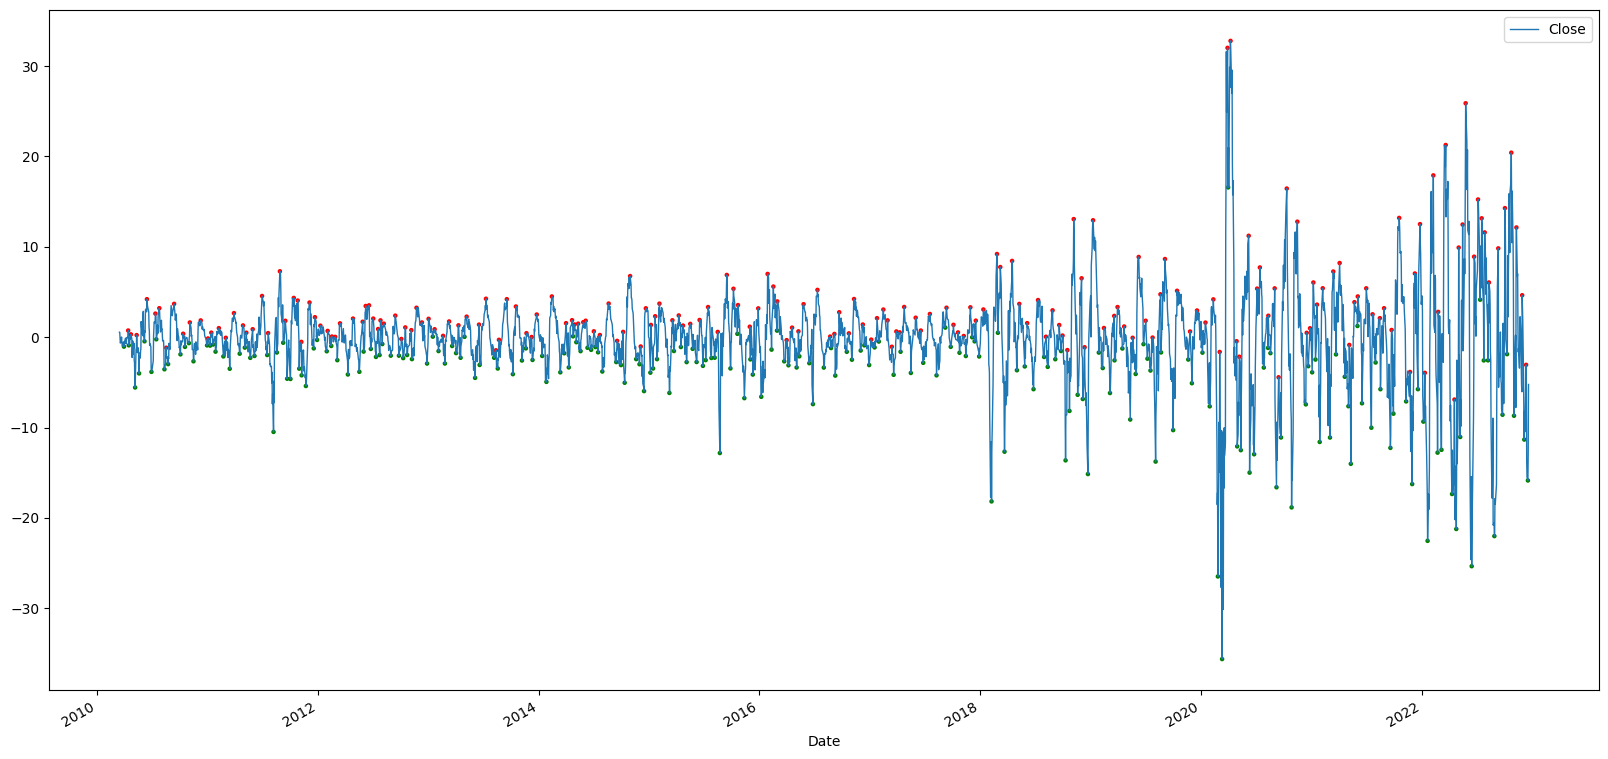

In [19]:
rcParams["figure.figsize"] = 20, 10
plt.figure(figsize=(50, 30))
prices_and_indicators_with_label[["Close"]].plot(
    kind="line", stacked=False, linewidth=1
)
buy_and_sell_preds = prices_and_indicators_with_label.query("Label != 0")
plt.scatter(
    x=buy_and_sell_preds.index,
    y=buy_and_sell_preds.Close,
    s=5,
    c=pltcolor(buy_and_sell_preds.Label),
)
plt.show()

<Figure size 5000x3000 with 0 Axes>

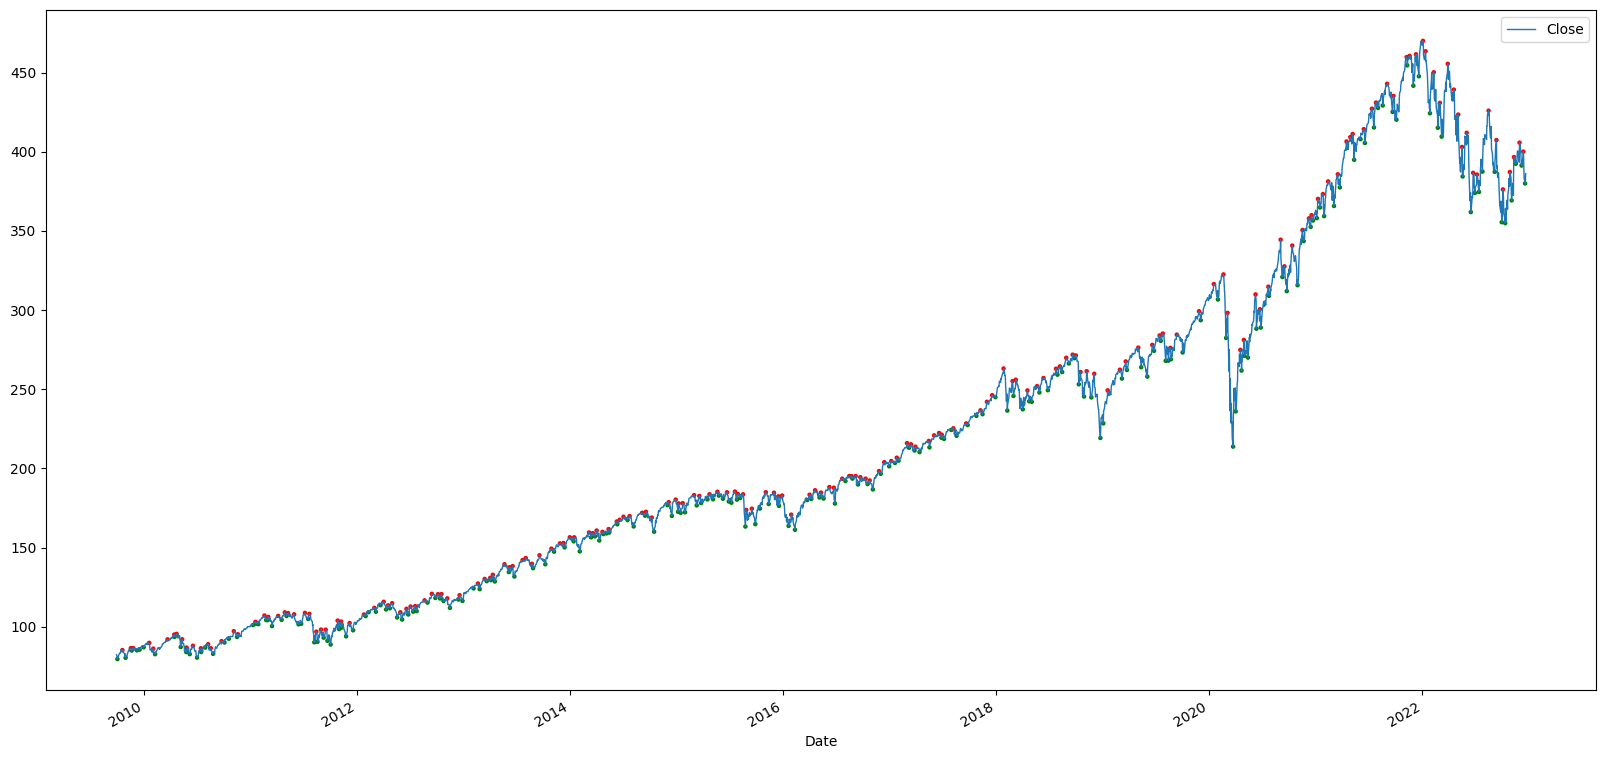

In [20]:
prices_with_label = create_labels(prices)
rcParams["figure.figsize"] = 20, 10
plt.figure(figsize=(50, 30))
prices_with_label[["Close"]].plot(kind="line", stacked=False, linewidth=1)
buy_and_sell_preds = prices_with_label.query("Label != 0")
plt.scatter(
    x=buy_and_sell_preds.index,
    y=buy_and_sell_preds.Close,
    s=5,
    c=pltcolor(buy_and_sell_preds.Label),
)
plt.show()

<h1 style="font-size:30px;"> <center> Creating Train & Test Data </center> </h1>

In [21]:
prices_and_indicators_with_label.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3217 entries, 2010-03-16 00:00:00-04:00 to 2022-12-21 00:00:00-05:00
Columns: 678 entries, Open to Label
dtypes: float64(676), int64(2)
memory usage: 16.7 MB


In [22]:
datas = []

for i in range(5, 13):
    train = prices_and_indicators_with_label.loc[
        (prices_and_indicators_with_label.index >= f"{2010+i-5}")
        & (prices_and_indicators_with_label.index <= f"{2010+i}")
    ]
    test = prices_and_indicators_with_label.loc[
        (prices_and_indicators_with_label.index >= f"{2010+i}")
        & (prices_and_indicators_with_label.index <= f"{2010+i+1}")
    ]
    datas.append([train, test])

<h1 style="font-size:30px;"> <center> Feature Selection </center> </h1>

In [23]:
for i in range(len(datas)):
    selected_feature_count = 30
    select = SelectKBest(score_func=f_classif, k=selected_feature_count)
    fitted = select.fit(datas[i][0].iloc[:, :-1], datas[i][0].iloc[:, -1])
    train_features = fitted.transform(datas[i][0].iloc[:, :-1])
    test_features = fitted.transform(datas[i][1].iloc[:, :-1])

    selected_features_boolean = select.get_support()
    features = list(datas[i][1].columns[:-1])
    selected_features = []
    for j in range(len(features)):
        if selected_features_boolean[j]:
            selected_features.append(features[j])
    train_label = datas[i][0].Label
    test_label = datas[i][1].Label

    datas[i][0] = pd.DataFrame(
        data=train_features.astype("float32"),
        columns=selected_features,
        index=datas[i][0].index,
    )
    datas[i][0]["Label"] = train_label
    datas[i][1] = pd.DataFrame(
        data=test_features.astype("float32"),
        columns=selected_features,
        index=datas[i][1].index,
    )
    datas[i][1]["Label"] = test_label

In [24]:
datas[0][0]

RSI-7    WILLR-7   STOCHF-7      CMO-7  \
Date                                                                    
2010-03-16 00:00:00-04:00  37.759014 -52.957394  55.301273 -24.481970   
2010-03-17 00:00:00-04:00  37.573631 -51.518074  68.045105 -24.852737   
2010-03-18 00:00:00-04:00  28.815044 -75.486748  30.960220 -42.369911   
2010-03-19 00:00:00-04:00  21.402075 -82.355774  19.091970 -57.195850   
2010-03-22 00:00:00-04:00  29.433516 -56.419857  46.038467 -41.132969   
...                              ...        ...        ...        ...   
2014-12-24 00:00:00-05:00  71.148331 -34.315838  40.716187  42.296658   
2014-12-26 00:00:00-05:00  72.135750 -34.939484  70.906624  44.271503   
2014-12-29 00:00:00-05:00  70.688393 -57.835812  50.266586  41.376785   
2014-12-30 00:00:00-05:00  57.358257 -95.801826   4.198170  14.716514   
2014-12-31 00:00:00-05:00  43.244396 -96.449310   3.676910 -13.511206   

                               RSI-8    WILLR-8   STOCHF-8      CMO-8  \
Date                                                                    
2010-03-16 00:00:00-04:00  39.590324 -58.703754  48.986355 -20.819353   
2010-03-17 00:00:00-04:00  39.431381 -53.441807  54.731819 -21.137236   
2010-03-18 00:00:00-04:00  31.710627 -78.285950  30.475998 -36.578747   
2010-03-19 00:00:00-04:00  24.677483 -84.928169  17.840006 -50.645035   
2010-03-22 00:00:00-04:00  31.282572 -56.810085  46.038467 -37.434856   
...                              ...        ...        ...        ...   
2014-12-24 00:00:00-05:00  69.421364 -33.947792  63.216438  38.842728   
2014-12-26 00:00:00-05:00  70.322250 -32.595474  43.688274  40.644493   
2014-12-29 00:00:00-05:00  69.128677 -35.885128  63.716152  38.257347   
2014-12-30 00:00:00-05:00  57.965584 -72.967125   4.198170  15.931165   
2014-12-31 00:00:00-05:00  45.506763 -96.449310   3.550690  -8.986471   

                               RSI-9    WILLR-9   STOCHF-9      CMO-9  \
Date                                                                    
2010-03-16 00:00:00-04:00  41.267151 -58.703754  47.042606 -17.465700   
2010-03-17 00:00:00-04:00  41.128399 -59.128994  48.481926 -17.743204   
2010-03-18 00:00:00-04:00  34.252930 -79.147545  24.513252 -31.494143   
2010-03-19 00:00:00-04:00  27.633904 -86.249077  17.644230 -44.732193   
2010-03-22 00:00:00-04:00  33.145233 -62.089603  43.580143 -33.709534   
...                              ...        ...        ...        ...   
2014-12-24 00:00:00-05:00  67.860695 -33.947792  65.684166  35.721397   
2014-12-26 00:00:00-05:00  68.696373 -32.245880  65.060516  37.392742   
2014-12-29 00:00:00-05:00  67.681129 -33.477676  42.164188  35.362263   
2014-12-30 00:00:00-05:00  58.092175 -45.273586   4.198170  16.184349   
2014-12-31 00:00:00-05:00  46.983044 -95.414177   3.550690  -6.033913   

                              RSI-10  STOCHF-10     CMO-10  STOCHF-11  \
Date                                                                    
2010-03-16 00:00:00-04:00  42.725075  41.296246 -14.549852  41.296246   
2010-03-17 00:00:00-04:00  42.602360  46.558193 -14.795279  40.871006   
2010-03-18 00:00:00-04:00  36.432571  21.714054 -27.134855  20.852453   
2010-03-19 00:00:00-04:00  30.235933  15.071829 -39.528133  13.750923   
2010-03-22 00:00:00-04:00  34.901157  43.189915 -30.197687  37.910397   
...                              ...        ...        ...        ...   
2014-12-24 00:00:00-05:00  66.457718  66.052208  32.915440  66.052208   
2014-12-26 00:00:00-05:00  67.240959  67.404526  34.481926  67.754120   
2014-12-29 00:00:00-05:00  66.358078  64.114868  32.716160  66.522324   
2014-12-30 00:00:00-05:00  57.962677  27.032875  15.925356  54.726414   
2014-12-31 00:00:00-05:00  47.960938   3.550690  -4.078121   4.585826   

                           STOCHRSI-16  STOCHRSI-17  STOCHRSI-18  STOCHRSI-19  \
Date                                                                            
2010-03-16 00:00:00-04:00    38.371651    37.563869    36.873486    3

In [25]:
datas[0][1]

RSI-7    WILLR-7    STOCHF-7      CMO-7  \
Date                                                                     
2015-01-02 00:00:00-05:00  42.521477 -77.038986   23.589367 -14.957045   
2015-01-05 00:00:00-05:00  27.883095 -95.156929    5.039090 -44.233810   
2015-01-06 00:00:00-05:00  24.230642 -89.828751   11.567208 -51.538715   
2015-01-07 00:00:00-05:00  43.844391 -59.277225   45.624859 -12.311219   
2015-01-08 00:00:00-05:00  58.889431 -14.810311   96.452911  17.778862   
2015-01-09 00:00:00-05:00  50.927258 -33.868111   71.318176   1.854515   
2015-01-12 00:00:00-05:00  44.741413 -48.080364   51.919636 -10.517174   
2015-01-13 00:00:00-05:00  43.234211 -52.852558   28.193401 -13.531582   
2015-01-14 00:00:00-05:00  39.824944 -63.247314   32.366791 -20.350109   
2015-01-15 00:00:00-05:00  34.618977 -85.802574   14.197423 -30.762049   
2015-01-16 00:00:00-05:00  50.638458 -47.138622   57.748066   1.276913   
2015-01-20 00:00:00-05:00  53.011330 -40.308247   65.209862   6.022663   
2015-01-21 00:00:00-05:00  57.421314 -21.009949   89.816910  14.842628   
2015-01-22 00:00:00-05:00  67.649719  -2.037338   97.775719  35.299435   
2015-01-23 00:00:00-05:00  58.621147 -20.071957   78.086243  17.242292   
2015-01-26 00:00:00-05:00  60.154312 -17.048090   77.783752  20.308626   
2015-01-27 00:00:00-05:00  45.778030 -52.396847   22.724201  -8.443939   
2015-01-28 00:00:00-05:00  37.933125 -96.091621    3.908380 -24.133753   
2015-01-29 00:00:00-05:00  50.618355 -49.400600   54.303490   1.236709   
2015-01-30 00:00:00-05:00  44.049179 -72.567810   33.076187 -11.901643   
2015-02-02 00:00:00-05:00  56.754768 -22.313469   94.011986  13.509534   
2015-02-03 00:00:00-05:00  65.209312  -0.134490   99.865509  30.418621   
2015-02-04 00:00:00-05:00  60.280022 -16.954283   83.045715  20.560041   
2015-02-05 00:00:00-05:00  65.149727  -2.201127   97.600754  30.299459   
2015-02-06 00:00:00-05:00  59.320576 -19.570892   78.768761  18.641150   
2015-02-09 00:00:00-05:00  52.539753 -37.582321   14.343835   5.079506   
2015-02-10 00:00:00-05:00  58.704456 -19.278925   58.123745  17.408911   
2015-02-11 00:00:00-05:00  55.000443 -59.544529   40.455471  10.000885   
2015-02-12 00:00:00-05:00  59.730469 -31.352087   68.647911  19.460934   
2015-02-13 00:00:00-05:00  59.307568 -32.991383   94.969177  18.615137   
2015-02-17 00:00:00-05:00  54.806240 -49.291103   71.868103   9.612484   
2015-02-18 00:00:00-05:00  50.109638 -52.584095   38.285469   0.219273   
2015-02-19 00:00:00-05:00  45.751896 -72.613144   27.386854  -8.496207   
2015-02-20 00:00:00-05:00  50.331089 -36.045238   65.117577   0.662181   
2015-02-23 00:00:00-05:00  43.178944 -59.502228   46.647366 -13.642110   
2015-02-24 00:00:00-05:00  41.515675 -64.537582   51.484962 -16.968653   
2015-02-25 00:00:00-05:00  35.590733 -84.069000   20.877340 -28.818531   
2015-02-26 00:00:00-05:00  30.817707 -79.771324   20.541727 -38.364586   
2015-02-27 00:00:00-05:00  25.577435 -98.456696    2.072791 -48.845131   
2015-03-02 00:00:00-05:00  38.501114 -68.519547   41.760109 -22.997774   
2015-03-03 00:00:00-05:00  31.747019 -73.522331   29.939133 -36.505962   
2015-03-04 00:00:00-05:00  26.866444 -76.826889   32.974056 -46.267113   
2015-03-05 00:00:00-05:00  27.966393 -72.700157   37.469318 -44.067215   
2015-03-06 00:00:00-05:00  17.482691 -92.828568    7.438821 -65.034622   
2015-03-09 00:00:00-04:00  27.503780 -75.610680   25.611610 -44.992439   
2015-03-10 00:00:00-04:00  18.937828 -99.288261    0.948450 -62.124344   
2015-03-11 00:00:00-04:00  21.189243 -95.881516    5.287739 -57.621513   
2015-03-12 00:00:00-04:00  45.575787 -34.706573   76.694771  -8.848429   
2015-03-13 00:00:00-04:00  42.547440 -46.537338   57.304989 -14.905118   
2015-03-16 00:00:00-04:00  59.046074  -1.782838   98.217163  18.092144   
2015-03-17 00:00:00-04:00  58.111435  -7.227619   92.563499  16.222870   
2015-03-18 00:00:00-04:00  67.670654  -8.798763   89.430443  35.341301   
2015-03-19 00:00:00-04:00  62.59678

In [26]:
for i in range(len(datas)):
    abs_scaler = MaxAbsScaler()
    abs_scaler.fit(datas[i][0])
    scaled_train = abs_scaler.transform(datas[i][0])
    scaled_test = abs_scaler.transform(datas[i][1])
    datas[i][0] = pd.DataFrame(
        data=scaled_train, columns=datas[i][0].columns, index=datas[i][0].index
    )
    datas[i][0]["Label"] = datas[i][0]["Label"] * 2
    datas[i][1] = pd.DataFrame(
        data=scaled_test, columns=datas[i][1].columns, index=datas[i][1].index
    )
    datas[i][1]["Label"] = datas[i][1]["Label"] * 2

In [27]:
datas[0][0]

RSI-7   WILLR-7  STOCHF-7     CMO-7     RSI-8  \
Date                                                                          
2010-03-16 00:00:00-04:00  0.445693 -0.529574  0.553013 -0.350318  0.481720   
2010-03-17 00:00:00-04:00  0.443504 -0.515181  0.680451 -0.355623  0.479786   
2010-03-18 00:00:00-04:00  0.340121 -0.754867  0.309602 -0.606280  0.385843   
2010-03-19 00:00:00-04:00  0.252622 -0.823558  0.190920 -0.818428  0.300266   
2010-03-22 00:00:00-04:00  0.347422 -0.564199  0.460385 -0.588581  0.380634   
...                             ...       ...       ...       ...       ...   
2014-12-24 00:00:00-05:00  0.839807 -0.343158  0.407162  0.605232  0.844693   
2014-12-26 00:00:00-05:00  0.851462 -0.349395  0.709066  0.633491  0.855654   
2014-12-29 00:00:00-05:00  0.834378 -0.578358  0.502666  0.592070  0.841131   
2014-12-30 00:00:00-05:00  0.677034 -0.958018  0.041982  0.210582  0.705303   
2014-12-31 00:00:00-05:00  0.510440 -0.964493  0.036769 -0.193335  0.553709   

                            WILLR-8  STOCHF-8     CMO-8     RSI-9   WILLR-9  \
Date                                                                          
2010-03-16 00:00:00-04:00 -0.587038  0.489864 -0.323429  0.516421 -0.587038   
2010-03-17 00:00:00-04:00 -0.534418  0.547318 -0.328367  0.514684 -0.591290   
2010-03-18 00:00:00-04:00 -0.782859  0.304760 -0.568252  0.428644 -0.791475   
2010-03-19 00:00:00-04:00 -0.849282  0.178400 -0.786772  0.345813 -0.862491   
2010-03-22 00:00:00-04:00 -0.568101  0.460385 -0.581551  0.414782 -0.620896   
...                             ...       ...       ...       ...       ...   
2014-12-24 00:00:00-05:00 -0.339478  0.632164  0.603423  0.849215 -0.339478   
2014-12-26 00:00:00-05:00 -0.325955  0.436883  0.631413  0.859672 -0.322459   
2014-12-29 00:00:00-05:00 -0.358851  0.637162  0.594329  0.846968 -0.334777   
2014-12-30 00:00:00-05:00 -0.729671  0.041982  0.247491  0.726971 -0.452736   
2014-12-31 00:00:00-05:00 -0.964493  0.035507 -0.139605  0.587950 -0.954142   

                           STOCHF-9     CMO-9    RSI-10  STOCHF-10    CMO-10  \
Date                                                                           
2010-03-16 00:00:00-04:00  0.470426 -0.291972  0.548751   0.412962 -0.259990   
2010-03-17 00:00:00-04:00  0.484819 -0.296611  0.547175   0.465582 -0.264376   
2010-03-18 00:00:00-04:00  0.245133 -0.526483  0.467932   0.217141 -0.484870   
2010-03-19 00:00:00-04:00  0.176442 -0.747782  0.388343   0.150718 -0.706325   
2010-03-22 00:00:00-04:00  0.435801 -0.563517  0.448262   0.431899 -0.539600   
...                             ...       ...       ...        ...       ...   
2014-12-24 00:00:00-05:00  0.656842  0.597149  0.853568   0.660522  0.588163   
2014-12-26 00:00:00-05:00  0.650605  0.625089  0.863628   0.674045  0.616154   
2014-12-29 00:00:00-05:00  0.421642  0.591146  0.852288   0.641149  0.584602   
2014-12-30 00:00:00-05:00  0.041982  0.270551  0.744459   0.270329  0.284569   
2014-12-31 00:00:00-05:00  0.035507 -0.100868  0.615999   0.035507 -0.072872   

                           STOCHF-11  STOCHRSI-16  STOCHRSI-17  STOCHRSI-18  \
Date                                                                          
2010-03-16 00:00:00-04:00   0.412962     0.383717     0.375639     0.368735   
2010-03-17 00:00:00-04:00   0.408710     0.437994     0.428332     0.420091   
2010-03-18 00:00:00-04:00   0.208525     0.000000     0.000000     0.000000   
2010-03-19 00:00:00-04:00   0.137509     0.000000     0.000000     0.000000   
2010-03-22 00:00:00-04:00   0.379104     0.280396     0.272570     0.265824   
...                              ...          ...          ...          ...   
2014-12-24 00:00:00-05:00   0.660522     0.389792     0.411420     0.429975   
2014-12-26 00:00:00-05:00   0.677541     0.410160     0.420258     0.429515   
2014-12-29 00:00:00-05:00   0.665223     0.063889     0.076190     0.087388   
2014-12-30 00:00:00-05:00   0.547264     0.000000     0.000000  

In [28]:
datas[0][1]

RSI-7   WILLR-7  STOCHF-7     CMO-7     RSI-8  \
Date                                                                          
2015-01-02 00:00:00-05:00  0.501907 -0.770390  0.235894 -0.214024  0.545770   
2015-01-05 00:00:00-05:00  0.329121 -0.951569  0.050391 -0.632951  0.378714   
2015-01-06 00:00:00-05:00  0.286009 -0.898288  0.115672 -0.737479  0.334763   
2015-01-07 00:00:00-05:00  0.517522 -0.592772  0.456249 -0.176164  0.539930   
2015-01-08 00:00:00-05:00  0.695108 -0.148103  0.964529  0.254402  0.704844   
2015-01-09 00:00:00-05:00  0.601125 -0.338681  0.713182  0.026537  0.618672   
2015-01-12 00:00:00-05:00  0.528110 -0.480804  0.519196 -0.150493  0.551173   
2015-01-13 00:00:00-05:00  0.510320 -0.528526  0.281934 -0.193626  0.534769   
2015-01-14 00:00:00-05:00  0.470078 -0.632473  0.323668 -0.291194  0.497882   
2015-01-15 00:00:00-05:00  0.408629 -0.858026  0.141974 -0.440181  0.441050   
2015-01-16 00:00:00-05:00  0.597716 -0.471386  0.577481  0.018272  0.609601   
2015-01-20 00:00:00-05:00  0.625725 -0.403082  0.652099  0.086180  0.635117   
2015-01-21 00:00:00-05:00  0.677779 -0.210099  0.898169  0.212386  0.682505   
2015-01-22 00:00:00-05:00  0.798511 -0.020373  0.977757  0.505107  0.795712   
2015-01-23 00:00:00-05:00  0.691941 -0.200720  0.780862  0.246724  0.702255   
2015-01-26 00:00:00-05:00  0.710038 -0.170481  0.777838  0.290601  0.718774   
2015-01-27 00:00:00-05:00  0.540346 -0.523968  0.227242 -0.120826  0.567497   
2015-01-28 00:00:00-05:00  0.447748 -0.960916  0.039084 -0.345335  0.481579   
2015-01-29 00:00:00-05:00  0.597479 -0.494006  0.543035  0.017696  0.615294   
2015-01-30 00:00:00-05:00  0.519939 -0.725678  0.330762 -0.170303  0.544505   
2015-02-02 00:00:00-05:00  0.669911 -0.223135  0.940120  0.193311  0.681159   
2015-02-03 00:00:00-05:00  0.769705 -0.001345  0.998655  0.435267  0.775244   
2015-02-04 00:00:00-05:00  0.711522 -0.169543  0.830457  0.294198  0.723193   
2015-02-05 00:00:00-05:00  0.769002 -0.022011  0.976008  0.433562  0.776696   
2015-02-06 00:00:00-05:00  0.700197 -0.195709  0.787688  0.266740  0.715776   
2015-02-09 00:00:00-05:00  0.620159 -0.375823  0.143438  0.072684  0.644361   
2015-02-10 00:00:00-05:00  0.692924 -0.192789  0.581237  0.249108  0.709152   
2015-02-11 00:00:00-05:00  0.649204 -0.595445  0.404555  0.143105  0.670600   
2015-02-12 00:00:00-05:00  0.705035 -0.313521  0.686479  0.278471  0.719862   
2015-02-13 00:00:00-05:00  0.700043 -0.329914  0.949692  0.266368  0.715573   
2015-02-17 00:00:00-05:00  0.646911 -0.492911  0.718681  0.137547  0.670197   
2015-02-18 00:00:00-05:00  0.591474 -0.525841  0.382855  0.003138  0.622449   
2015-02-19 00:00:00-05:00  0.540037 -0.726131  0.273869 -0.121574  0.577641   
2015-02-20 00:00:00-05:00  0.594088 -0.360452  0.651176  0.009475  0.622097   
2015-02-23 00:00:00-05:00  0.509667 -0.595022  0.466474 -0.195208  0.548729   
2015-02-24 00:00:00-05:00  0.490035 -0.645376  0.514850 -0.242808  0.531419   
2015-02-25 00:00:00-05:00  0.420099 -0.840690  0.208773 -0.412371  0.468811   
2015-02-26 00:00:00-05:00  0.363760 -0.797713  0.205417 -0.548967  0.416631   
2015-02-27 00:00:00-05:00  0.301906 -0.984567  0.020728 -0.698936  0.357142   
2015-03-02 00:00:00-05:00  0.454452 -0.685195  0.417601 -0.329080  0.483836   
2015-03-03 00:00:00-05:00  0.374729 -0.735223  0.299391 -0.522372  0.411118   
2015-03-04 00:00:00-05:00  0.317121 -0.768269  0.329741 -0.662046  0.356730   
2015-03-05 00:00:00-05:00  0.330104 -0.727002  0.374693 -0.630568  0.367660   
2015-03-06 00:00:00-05:00  0.206359 -0.928286  0.074388 -0.930595  0.245705   
2015-03-09 00:00:00-04:00  0.324644 -0.756107  0.256116 -0.643807  0.349605   
2015-03-10 00:00:00-04:00  0.223535 -0.992883  0.009484 -0.888951  0.251445   
2015-03-11 00:00:00-04:00  0.250109 -0.958815  0.052877 -0.824519  0.275199   
2015-03-12 00:00:00-04:00  0.537959 -0.347066  0.766948 -0.126614  0.538841   
2015-03-13 00:00:00-04:00  0.502213 -0.465373  0.573050 -0.213281  0.506862   
2

<h1 style="font-size:30px;"> <center> Controling Null Values </center> </h1>

In [29]:
total_na_count = 0
for data in datas:
    total_na_count += number_null_and_nan(data[0])
    total_na_count += number_null_and_nan(data[1])
print(f"Total null and nan values = {total_na_count}")

Total null and nan values = 0


<h1 style="font-size:40px;"> <center> INITIAL MODELS </center> </h1>

<h1 style="font-size:30px;"> Model Architectures </h1>

In [30]:
def create_model_MLP(activation_func="swish", dropout_rate=0.2, optimizer_algo="adam"
):
    MLP = Sequential()
    MLP.add(
        Dense(
            64,
            input_shape=(30, ),
            activation=activation_func,
            kernel_initializer=tf.keras.initializers.HeUniform(),
        )
    )
    MLP.add(BatchNormalization())
    MLP.add(Dense(32, activation=activation_func))
    MLP.add(Dropout(dropout_rate))
    MLP.add(Dense(32, activation=activation_func))
    MLP.add(Dropout(dropout_rate))
    MLP.add(Dense(3, activation="softmax"))
    MLP.compile(
        loss="categorical_crossentropy",
        optimizer=optimizer_algo,
        metrics=[
            "accuracy",
            "Precision",
            "Recall",
            "AUC",
            tfa.metrics.F1Score(num_classes=3, average="macro"),
        ],
    )
    return MLP

In [31]:
def create_model_LSTM(
    activation_func="swish", dropout_rate=0.2, optimizer_algo="adam"
):
    LSTM_model = Sequential()
    LSTM_model.add(
        LSTM(
            units=64,
            return_sequences=True,
            input_shape=(30, 30),
            activation=activation_func,
            kernel_initializer=tf.keras.initializers.GlorotUniform(),
        )
    )
    LSTM_model.add(BatchNormalization())
    LSTM_model.add(LSTM(units=32, return_sequences=True, activation=activation_func))
    LSTM_model.add(BatchNormalization())
    LSTM_model.add(Dropout(dropout_rate))
    LSTM_model.add(LSTM(units=32, return_sequences=False, activation=activation_func))
    LSTM_model.add(BatchNormalization())
    LSTM_model.add(Dropout(dropout_rate))
    LSTM_model.add(Dense(3, activation="softmax"))
    LSTM_model.compile(
        loss="categorical_crossentropy",
        optimizer=optimizer_algo,
        metrics=[
            "accuracy",
            "Precision",
            "Recall",
            "AUC",
            tfa.metrics.F1Score(num_classes=3, average="macro"),
        ],
    )
    return LSTM_model

In [32]:
def create_model_GRU(
    activation_func="swish", dropout_rate=0.2, optimizer_algo="adam"
):
    GRU_model = Sequential()
    GRU_model.add(
        GRU(
            units=64,
            return_sequences=True,
            input_shape=(30, 30),
            activation=activation_func,
            kernel_initializer=tf.keras.initializers.GlorotUniform(),
        )
    )
    GRU_model.add(BatchNormalization())
    GRU_model.add(GRU(units=32, return_sequences=True, activation=activation_func))
    GRU_model.add(BatchNormalization())
    GRU_model.add(Dropout(dropout_rate))
    GRU_model.add(GRU(units=32, return_sequences=False, activation=activation_func))
    GRU_model.add(BatchNormalization())
    GRU_model.add(Dropout(dropout_rate))
    GRU_model.add(Dense(3, activation="softmax"))
    GRU_model.compile(
        loss="categorical_crossentropy",
        optimizer=optimizer_algo,
        metrics=[
            "accuracy",
            "Precision",
            "Recall",
            "AUC",
            tfa.metrics.F1Score(num_classes=3, average="macro"),
        ],
    )
    return GRU_model

In [33]:
def create_model_CNN_2D(
    activation_func="relu",
    dropout_rate=0.2,
    optimizer_algo="adam",
    kernel=3,
    pooling=3,
):
    CNN_2D = Sequential()
    CNN_2D.add(
        Conv2D(
            filters=64,
            kernel_size=(kernel, kernel),
            input_shape=(30, 30, 1),
            padding="same",
            activation=activation_func,
            kernel_initializer=tf.keras.initializers.HeUniform(),
        )
    )
    CNN_2D.add(BatchNormalization())
    CNN_2D.add(MaxPooling2D(pool_size=(pooling, pooling), padding="same"))
    CNN_2D.add(BatchNormalization())
    CNN_2D.add(
        Conv2D(
            filters=64,
            kernel_size=(kernel, kernel),
            padding="same",
            activation=activation_func,
        )
    )
    CNN_2D.add(BatchNormalization())
    CNN_2D.add(MaxPooling2D(pool_size=(pooling, pooling), padding="same"))
    CNN_2D.add(BatchNormalization())
    CNN_2D.add(Dropout(dropout_rate))
    CNN_2D.add(Flatten())
    CNN_2D.add(Dense(32, activation=activation_func))
    CNN_2D.add(Dropout(dropout_rate))
    CNN_2D.add(Dense(3, activation="softmax"))
    CNN_2D.compile(
        loss="categorical_crossentropy",
        optimizer=optimizer_algo,
        metrics=[
            "accuracy",
            "Precision",
            "Recall",
            "AUC",
            tfa.metrics.F1Score(num_classes=3, average="macro"),
        ],
    )
    return CNN_2D

<h1 style="font-size:30px;"> Train&Test Methods </h1>

In [57]:
def model_train_test(model_name, datas, parameters=None):
    set_random_seed()

    start_time = time.time()
    predictions = []
    f1_scores = []
    
    model_creations = {"MLP": create_model_MLP, "LSTM": create_model_LSTM, 
                   "GRU": create_model_GRU, "CNN-2D": create_model_CNN_2D }
    create_model = model_creations[model_name]

    for i in range(len(datas)):
        OUTPUT_PATH = "./outputs"
        es = EarlyStopping(
            monitor="val_f1_score", mode="max", verbose=1, patience=30, min_delta=1e-3
        )
        mcp = ModelCheckpoint(
            os.path.join(OUTPUT_PATH, f"best_{model_name}_model-{i+1}.h5"),
            monitor="val_f1_score",
            verbose=0,
            save_best_only=True,
            save_weights_only=False,
            mode="max",
        )
        
        
        if model_name == "MLP":     
            val_split_point = int(0.8 * len(datas[i][0]))
            X_train = datas[i][0][:val_split_point].iloc[:, :-1]
            y_train = tf.keras.utils.to_categorical(
                datas[i][0][:val_split_point].iloc[:, -1], num_classes=3
            )
            X_val = datas[i][0][val_split_point:].iloc[:, :-1]
            y_val = tf.keras.utils.to_categorical(
                datas[i][0][val_split_point:].iloc[:, -1], num_classes=3
            )
            X_test = datas[i][1].iloc[:, :-1]
            y_test = datas[i][1].iloc[:, -1]
        else:
            val_split_point = int(0.8 * len(datas[0][i]))
            X_train = datas[0][i][:val_split_point]
            y_train = datas[1][i][:val_split_point]
            X_val = datas[0][i][val_split_point:]
            y_val = datas[1][i][val_split_point:]
            X_test = datas[2][i]
            y_test = datas[3][i]

        if parameters == None:    
            model = create_model()
            batch_size = 32
        else:
            model = create_model(parameters["activation_func"], parameters["dropout_rate"], 
                                 parameters["optimizer_algo"])
            batch_size=parameters["batch_size"]
        model.fit(
            X_train,
            y_train,
            batch_size=batch_size,
            epochs=20,
            verbose=0,
            #callbacks=[es, mcp],
            validation_data=(X_val, y_val),
            class_weight={0: 1, 1: 10, 2: 10},
        )
        y_pred = model.predict(X_test)
        y_pred = y_pred.argmax(axis=-1)
        #print(y_test)
        #print(y_pred)
        predictions.append(y_pred)
        f1_scores.append(f1_score(y_test, y_pred, average="macro"))

    print(f"\Mean f1-macro score: {np.mean(f1_scores)}, Std of f1-macro score: {np.std(f1_scores)}\n")
    minutes = round(int(time.time() - start_time) / 60, 2)
    print(f"\nCompleted in {minutes} minutes\n")
    return predictions

<h1 style="font-size:30px;"> Hyperparameter Optimization Methods </h1>

In [35]:
def model_ho(model_name, datas, parameter_space):
    set_random_seed()
    start_time = time.time()
    model_creations = {"MLP": create_model_MLP, "LSTM": create_model_LSTM, 
                   "GRU": create_model_GRU, "CNN-2D": create_model_CNN_2D }

    def objective(trial):
        activation_func = trial.suggest_categorical(
            name="activation_func", choices=parameter_space["activation_func"]
        )
        dropout_rate = trial.suggest_categorical("dropout_rate", parameter_space["dropout_rate"])
        optimizer_algo = trial.suggest_categorical(
            "optimizer_algo", parameter_space["optimizer_algo"]
        )
        batch_size = trial.suggest_categorical("batch_size", parameter_space["batch_size"])
        #lr_max = trial.suggest_categorical("learning_rate_max", [1e-1, 1e-2, 1e-3, 1e-4])
     
        create_model = model_creations[model_name]
        model = create_model_MLP(activation_func, dropout_rate, optimizer_algo)

        f1_scores = []

        for i in range(len(datas)):
            OUTPUT_PATH = "./outputs"
            es = EarlyStopping(
                monitor="f1_score", mode="max", verbose=1, patience=30, min_delta=1e-3
            )
            mcp = ModelCheckpoint(
                os.path.join(OUTPUT_PATH, f"best_CNN_model-{i+1}.h5"),
                monitor="f1_score",
                verbose=0,
                save_best_only=True,
                save_weights_only=False,
                mode="max",
            )


            
            if model_name == "MLP":     
                val_split_point = int(0.8 * len(datas[i][0]))
                X_train = datas[i][0][:val_split_point].iloc[:, :-1]
                y_train = tf.keras.utils.to_categorical(
                    datas[i][0][:val_split_point].iloc[:, -1], num_classes=3
                )
                X_val = datas[i][0][val_split_point:].iloc[:, :-1]
                y_val = datas[i][0][val_split_point:].iloc[:, -1]
            else:
                val_split_point = int(0.8 * len(datas[0][i]))
                X_train = datas[0][i][:val_split_point]
                y_train = datas[1][i][:val_split_point]
                X_val = datas[0][i][val_split_point:]
                y_val = datas[1][i][val_split_point:]
                y_val = y_val.argmax(axis=-1)

            model = create_model(activation_func, dropout_rate, optimizer_algo)
            model.fit(
                X_train,
                y_train,
                batch_size=batch_size,
                epochs=5,
                verbose=0,
                callbacks=[es, mcp],
                class_weight={0: 1, 1: 10, 2: 10},
            )
            y_pred = model.predict(X_val)
            y_pred = y_pred.argmax(axis=-1)
            f1_scores.append(f1_score(y_val, y_pred, average="macro"))
        return np.mean(f1_scores)
    



    study = optuna.create_study(
        study_name=f"{model_name}_Bayesian_Optimization",
        direction="maximize",
        sampler=optuna.samplers.TPESampler(seed=SEED),
    )
    study.optimize(objective, n_trials=5)
    trial = study.best_trial

    print("\n------------------------------------------")
    print("Best F1 Macro: {}".format(trial.value))
    print("Best hyperparameters: {}".format(trial.params))
    minutes = round(int(time.time() - start_time) / 60, 2)
    print(f"\nCompleted in {minutes} minutes")
    return trial.params

<h1 style="font-size:30px;"> Matrix Data Creation </h1>

In [36]:
two_d_datas = []

for i in range(len(datas)):
    df = datas[i][0].drop(columns=["Label"])
    df_matrix_train = pd.DataFrame(
        index=df.iloc[29:].index,
    )
    df_matrix_train["Image"] = [np.zeros((30, 30))] * df.iloc[29:].shape[0]

    for j in range(df_matrix_train.shape[0]):
        matrix = df.iloc[j : j + 30].values.reshape((30, 30, -1))
        df_matrix_train.iloc[j, 0] = matrix
    df_matrix_train["Label"] = datas[i][0].iloc[29:, -1]

    df = datas[i][1].drop(columns=["Label"])
    df_matrix_test = pd.DataFrame(
        index=df.iloc[29:].index,
    )
    df_matrix_test["Image"] = [np.zeros((30, 30))] * df.iloc[29:].shape[0]

    for j in range(df_matrix_test.shape[0]):
        matrix = df.iloc[j : j + 30].values.reshape((30, 30, -1))
        df_matrix_test.iloc[j, 0] = matrix
    df_matrix_test["Label"] = datas[i][1].iloc[29:, -1]

    two_d_datas.append((df_matrix_train, df_matrix_test))

In [37]:
X_train_list = []
y_train_list = []
X_test_list = []
y_test_list = []
matrix_datas = []

for i in range(len(two_d_datas)):
    X_train = []
    y_train = []
    X_test = []
    y_test = []

    for j in range(two_d_datas[i][0].shape[0]):
        X_train.append(two_d_datas[i][0].iloc[j, 0])
        y_train.append(
            tf.keras.utils.to_categorical(two_d_datas[i][0].iloc[j, 1], num_classes=3)
        )
    X_train, y_train = np.array(X_train), np.array(y_train)
    X_train = np.reshape(
        X_train, newshape=(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
    )
    X_train_list.append(X_train)
    y_train_list.append(y_train)

    for j in range(two_d_datas[i][1].shape[0]):
        X_test.append(two_d_datas[i][1].iloc[j, 0])
        y_test.append(two_d_datas[i][1].iloc[j, 1])
    X_test, y_test = np.array(X_test), np.array(y_test)
    X_test = np.reshape(
        X_test, newshape=(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
    )
    X_test_list.append(X_test)
    y_test_list.append(y_test)
    
matrix_datas = [X_train_list, y_train_list, X_test_list, y_test_list]

<h1 style="font-size:30px;"> <center> MLP </center> </h1>

In [58]:
mlp_predictions = model_train_test("MLP", datas)

8/8 [==============================] - 0s 3ms/step
\Mean f1-macro score: 0.5382379561231587, Std of f1-macro score: 0.04332252101615212


Completed in 0.8 minutes



In [64]:
type(mlp_predictions[0])

numpy.ndarray

(2008,)

<h1 style="font-size:30px;"> <center> LSTM </center> </h1>

In [ ]:
model_train_test("LSTM", matrix_datas)

<h1 style="font-size:30px;"> <center> GRU </center> </h1>

In [ ]:
model_train_test("GRU", matrix_datas)

<h1 style="font-size:30px;"> <center> CNN </center> </h1>

In [ ]:
model_train_test("CNN-2D", matrix_datas)

<h1 style="font-size:40px;"> <center> HYPERPARAMETER TUNING </center> </h1>

<h1 style="font-size:30px;"> <center> MLP </center> </h1>

In [ ]:
mlp_parameter_space = {"activation_func":["relu", "selu", "swish"], "dropout_rate":[0.1, 0.2, 0.3],
                      "optimizer_algo":["adam", "adadelta", "rmsprop"], "batch_size":[32, 64, 256]}

In [ ]:
best_mlp_parameters = model_ho("MLP", datas, mlp_parameter_space)

In [ ]:
mlp_predictions = model_train_test("MLP", datas, best_mlp_parameters)
mlp_prediction = np.concatenate(mlp_predictions)

<h1 style="font-size:30px;"> <center> LSTM </center> </h1>

In [ ]:
lstm_parameter_space = {"activation_func":["tanh", "swish"], "dropout_rate":[0.2, 0.3, 0.4],
                      "optimizer_algo":["adam", "adadelta", "rmsprop"], "batch_size":[32, 64, 256]}

In [ ]:
best_lstm_parameters = model_ho("LSTM", matrix_datas, lstm_parameter_space)

In [ ]:
model_train_test("LSTM", matrix_datas, best_lstm_parameters)

<h1 style="font-size:30px;"> <center> GRU </center> </h1>

In [ ]:
gru_parameter_space = {"activation_func":["tanh", "swish"], "dropout_rate":[0.2, 0.3, 0.4],
                      "optimizer_algo":["adam", "adadelta", "rmsprop"], "batch_size":[32, 64, 256]}

In [ ]:
best_gru_parameters = model_ho("GRU", matrix_datas, gru_parameter_space)

In [ ]:
model_train_test("GRU", matrix_datas, best_gru_parameters)

<h1 style="font-size:30px;"> <center> CNN </center> </h1>

In [ ]:
cnn2d_parameter_space = {"activation_func":["relu", "selu", "swish"], "dropout_rate":[0.3, 0.4, 0.5],
                      "optimizer_algo":["adam", "adadelta", "rmsprop"], "batch_size":[32, 64, 256]}

In [ ]:
best_cnn2d_parameters = model_ho("CNN-2D", matrix_datas, cnn2d_parameter_space)

In [ ]:
model_train_test("CNN-2D", matrix_datas, best_cnn2d_parameters)

<h1 style="font-size:40px;"> <center> CLASSIFICATION EVALUATION </center> </h1>

In [78]:
test_labels = prices_and_indicators_with_label.loc[(prices_and_indicators_with_label.index >= "2015") & (prices_and_indicators_with_label.index <= "2023")][["Label"]]
test_labels

Label
Date                            
2015-01-02 00:00:00-05:00      0
2015-01-05 00:00:00-05:00      0
2015-01-06 00:00:00-05:00      1
2015-01-07 00:00:00-05:00      0
2015-01-08 00:00:00-05:00      2
...                          ...
2022-12-15 00:00:00-05:00      0
2022-12-16 00:00:00-05:00      0
2022-12-19 00:00:00-05:00      1
2022-12-20 00:00:00-05:00      0
2022-12-21 00:00:00-05:00      0

[2008 rows x 1 columns]

In [81]:
mlp_prediction

array([0, 1, 1, ..., 1, 1, 0], dtype=int64)

In [89]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plot

In [107]:
print(classification_report(test_labels["Label"], mlp_prediction, target_names=["Hold","Buy","Sell"]))

              precision    recall  f1-score   support

        Hold       0.96      0.66      0.79      1748
         Buy       0.28      0.86      0.43       132
        Sell       0.25      0.80      0.39       128

    accuracy                           0.69      2008
   macro avg       0.50      0.78      0.53      2008
weighted avg       0.87      0.69      0.74      2008



In [108]:
import matplotlib.pyplot as plt
import numpy as np

def show_values(pc, fmt="%.2f", **kw):
    '''
    Heatmap with text in each cell with matplotlib's pyplot
    Source: https://stackoverflow.com/a/25074150/395857 
    By HYRY
    '''
    from itertools import izip
    pc.update_scalarmappable()
    ax = pc.get_axes()
    #ax = pc.axes# FOR LATEST MATPLOTLIB
    #Use zip BELOW IN PYTHON 3
    for p, color, value in izip(pc.get_paths(), pc.get_facecolors(), pc.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.all(color[:3] > 0.5):
            color = (0.0, 0.0, 0.0)
        else:
            color = (1.0, 1.0, 1.0)
        ax.text(x, y, fmt % value, ha="center", va="center", color=color, **kw)


def cm2inch(*tupl):
    '''
    Specify figure size in centimeter in matplotlib
    Source: https://stackoverflow.com/a/22787457/395857
    By gns-ank
    '''
    inch = 2.54
    if type(tupl[0]) == tuple:
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)


def heatmap(AUC, title, xlabel, ylabel, xticklabels, yticklabels, figure_width=40, figure_height=20, correct_orientation=False, cmap='RdBu'):
    '''
    Inspired by:
    - https://stackoverflow.com/a/16124677/395857 
    - https://stackoverflow.com/a/25074150/395857
    '''

    # Plot it out
    fig, ax = plt.subplots()    
    #c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap='RdBu', vmin=0.0, vmax=1.0)
    c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap=cmap)

    # put the major ticks at the middle of each cell
    ax.set_yticks(np.arange(AUC.shape[0]) + 0.5, minor=False)
    ax.set_xticks(np.arange(AUC.shape[1]) + 0.5, minor=False)

    # set tick labels
    #ax.set_xticklabels(np.arange(1,AUC.shape[1]+1), minor=False)
    ax.set_xticklabels(xticklabels, minor=False)
    ax.set_yticklabels(yticklabels, minor=False)

    # set title and x/y labels
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)      

    # Remove last blank column
    plt.xlim( (0, AUC.shape[1]) )

    # Turn off all the ticks
    ax = plt.gca()    
    for t in ax.xaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False
    for t in ax.yaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False

    # Add color bar
    plt.colorbar(c)

    # Add text in each cell 
    show_values(c)

    # Proper orientation (origin at the top left instead of bottom left)
    if correct_orientation:
        ax.invert_yaxis()
        ax.xaxis.tick_top()       

    # resize 
    fig = plt.gcf()
    #fig.set_size_inches(cm2inch(40, 20))
    #fig.set_size_inches(cm2inch(40*4, 20*4))
    fig.set_size_inches(cm2inch(figure_width, figure_height))



def plot_classification_report(classification_report, title='Classification report ', cmap='RdBu'):
    '''
    Plot scikit-learn classification report.
    Extension based on https://stackoverflow.com/a/31689645/395857 
    '''
    lines = classification_report.split('\n')

    classes = []
    plotMat = []
    support = []
    class_names = []
    for line in lines[2 : (len(lines) - 2)]:
        t = line.strip().split()
        if len(t) < 2: continue
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        support.append(int(t[-1]))
        class_names.append(t[0])
        print(v)
        plotMat.append(v)

    print('plotMat: {0}'.format(plotMat))
    print('support: {0}'.format(support))

    xlabel = 'Metrics'
    ylabel = 'Classes'
    xticklabels = ['Precision', 'Recall', 'F1-score']
    yticklabels = ['{0} ({1})'.format(class_names[idx], sup) for idx, sup  in enumerate(support)]
    figure_width = 25
    figure_height = len(class_names) + 7
    correct_orientation = False
    heatmap(np.array(plotMat), title, xlabel, ylabel, xticklabels, yticklabels, figure_width, figure_height, correct_orientation, cmap=cmap)


<AxesSubplot:>

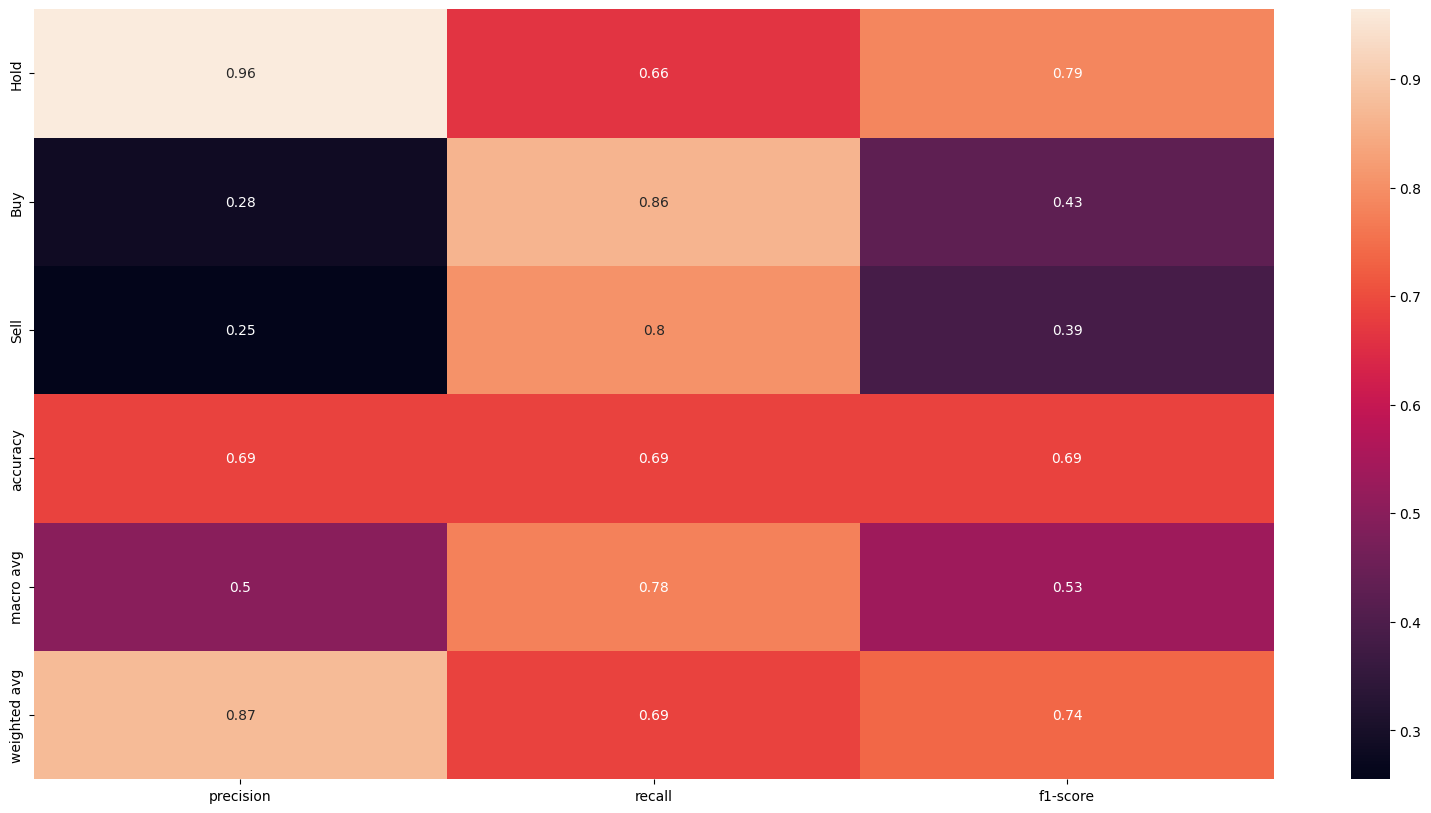

In [117]:
sampleClassificationReport = classification_report(test_labels["Label"], mlp_prediction, target_names=["Hold","Buy","Sell"], output_dict=True)


import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report
import pandas as pd

sns.heatmap(pd.DataFrame(sampleClassificationReport).iloc[:-1, :].T, annot=True)

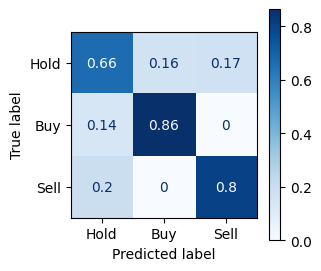

In [105]:
disp = ConfusionMatrixDisplay.from_predictions(test_labels["Label"], mlp_prediction,
                           display_labels=["Hold","Buy","Sell"], 
                              cmap=plot.cm.Blues, 
                              normalize="true"
                             )
fig = disp.ax_.get_figure() 
fig.set_figwidth(3)
fig.set_figheight(3) 

<h1 style="font-size:40px;"> <center> FINANCIAL EVALUATION </center> </h1>

In [72]:
test_prices = prices.loc[(prices.index >= "2015") & (prices.index <= "2023")].iloc[:-6]
test_prices

Open        High         Low       Close  \
Date                                                                        
2015-01-02 00:00:00-05:00  178.284335  178.716267  176.383823  177.463654   
2015-01-05 00:00:00-05:00  176.375131  176.547902  173.939041  174.258667   
2015-01-06 00:00:00-05:00  174.578271  175.122510  171.787994  172.617310   
2015-01-07 00:00:00-05:00  173.999533  175.122559  173.533052  174.768372   
2015-01-08 00:00:00-05:00  176.236896  178.094211  176.219628  177.869598   
...                               ...         ...         ...         ...   
2022-12-15 00:00:00-05:00  392.497635  393.443305  386.116962  387.848999   
2022-12-16 00:00:00-05:00  385.179993  386.579987  381.040009  383.269989   
2022-12-19 00:00:00-05:00  383.470001  383.820007  378.279999  380.019989   
2022-12-20 00:00:00-05:00  379.230011  382.230011  377.850006  380.540009   
2022-12-21 00:00:00-05:00  383.250000  387.410004  382.690002  386.230011   

                              Volume  
Date                                  
2015-01-02 00:00:00-05:00  121465900  
2015-01-05 00:00:00-05:00  169632600  
2015-01-06 00:00:00-05:00  209151400  
2015-01-07 00:00:00-05:00  125346700  
2015-01-08 00:00:00-05:00  147217800  
...                              ...  
2022-12-15 00:00:00-05:00  117705900  
2022-12-16 00:00:00-05:00  119858000  
2022-12-19 00:00:00-05:00   79878100  
2022-12-20 00:00:00-05:00   74427200  
2022-12-21 00:00:00-05:00   78167400  

[2008 rows x 5 columns]

<h1 style="font-size:30px;"> <center> MLP </center> </h1>

In [71]:
holdLabel:int = 0
buyLabel:int = 1
sellLabel:int = 2
ticker:str = "SPY"
benchmark_ticker:str = "SPY"
ohlcv:pd.DataFrame = test_prices
predictions:np.array = mlp_prediction
risk_free_rate:float = 0.01/252
initial_capital:float = 1000
commission:float = 1
alpha:float = 0.05
threshold:float = 0
order:int = 1
order_type:str = "market" # "market" or "limit"
short:bool = False
short_fee:float = 1
trailing_take_profit:bool = False
take_profit:float = 5
trailing_stop_loss:bool = False
stop_loss:float = 5
leverage:int = 1
miss_rate:int = 10
show_initial_configuration: bool = True
show_tables:bool = True 
show_charts:bool = True
show_time:bool = True
precision_point = 3

metrics = financial_evaluation(holdLabel, buyLabel, sellLabel, ticker, benchmark_ticker, ohlcv, predictions, risk_free_rate, initial_capital,
                              commission, alpha, threshold, order, order_type, short, short_fee, trailing_take_profit, take_profit,
                              trailing_stop_loss, stop_loss, leverage, miss_rate, show_initial_configuration,
                              show_tables, show_charts, show_time, precision_point)


Backtest was completed in 0 minutes and 0.62 seconds.



<h1 style="font-size:30px;"> <center> LSTM </center> </h1>

<h1 style="font-size:30px;"> <center> GRU </center> </h1>

<h1 style="font-size:30px;"> <center> CNN </center> </h1>